<a href="https://www.kaggle.com/code/calistusmwonga/cnn-xgbm-sotr-efficientnetv2b0173ef58638?scriptVersionId=254960407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **CLASSIFICATION FOR LANDSLIDE DETECTION**


# 1. **Business Understanding**

## 1.1 Problem Statement

- Landslides are critical natural hazards, often triggered by extreme weather and seismic events. The impact on human lives, property, and infrastructure is significant, making rapid and accurate detection essential for effective disaster management and climate resilience planning.
- Traditional monitoring methods relying solely on optical satellite imagery often fail due to persistent cloud cover, which is frequently present during the storm events that trigger landslides. This delay in detection creates a critical information gap, That hampers risk assessment when they are needed most. There is a clear business need for a reliable detection system that functions under all weather conditions, especially in remote or inaccessible regions.

## 1.2 Project Aim:
- The aim of this project is to develop an AI-based system for detecting and classifying landslides using satellite and radar imagery. This system will support disaster management agencies by providing timely and reliable detection, and will assist geospatial researchers in understanding patterns and impacts of landslide events.

## 1.3 Project Objectives
To address this problem, this project will deliver an AI system with the following primary objectives:
1. To build and evaluate a machine learning model capable of accurately classifying landslide events by synergistically using both all-weather Synthetic Aperture Radar (SAR) data and traditional optical satellite imagery.
2. To perform domain-specific feature engineering by testing out various engineered features to determine whether they offer a stronger predictive signal than the raw spatial patterns alone.  
3. To implement Explainable AI (XAI) techniques using SHARP on the most successful model. This is to prevent developing a black-box model and instead provide a clear understanding into how the model came to it's coLnclusion by understanding which features are driving the detection of a landslide which makes it trustworthy for stakeholders



# 2. Data Understanding

## **2.1 Data Source** 
The dataset for this challenge is from https://zindi.africa/competitions/classification-for-landslide-detection/data 
- It contains multi-modal collection, combining satellite imagery from two distinct sources to provide a comprehensive view of ground conditions.
  
**These two types of data are:**
1. *Optical Imagery (Sentinel-2)*: This data is sourced from the Sentinel-2 MultiSpectral Instrument (MSI). It provides high-resolution (10m) Red, Green, Blue, and Near-Infrared (NIR) bands. While it is highly interpretable, optical data is susceptible to obstruction by cloud cover.
2. *Radar Imagery (Sentinel-1):* This data provides all-weather imaging capabilities, which is crucial for monitoring events in cloud-covered regions. It includes Synthetic Aperture Radar (SAR) data with VV (Vertical-Vertical) and VH (Vertical-Horizontal) polarizations, also at a 10m resolution.

#### The files provided for this project are as follows:
| **File Name**                      | **Description**                                                                                         |
| ---------------------------------- | ------------------------------------------------------------------------------------------------------- |
| `Train.csv` / `Test.csv`           | Metadata files containing the image IDs and, for the training set, the target label (1 for landslide).  |
| `train_data.zip` / `test_data.zip` | Contains the multi-band image data as individual `.npy` files, corresponding to the IDs in the CSVs.    |
| `Trustworthiness Evaluation.pdf`   | A document outlining the criteria for building trustworthy and ethical AI solutions for this challenge. |


## 2.2 Data Description and Attributes
Each .npy file contains a 12-channel image array. These bands, represent a fusion of optical and radar data captured post-event, along with pre-calculated change detection bands.

Band Breakdown: <br>
 **Optical Bands (Sentinel-2):** These provide visual information about the landscape.
- Band 1: Red
- Band 2: Green
- Band 3: Blue
- Band 4: Near-Infrared (NIR) <br>
**SAR Bands - Descending Orbit (Sentinel-1):** Radar data from the satellite's descending pass.
- Band 5: VV Polarization (Post-Event)
- Band 6: VH Polarization (Post-Event)
- Band 7: VV Change Detection (Difference)
- Band 8: VH Change Detection (Difference) <br>
**SAR Bands - Ascending Orbit (Sentinel-1):** Radar data from the satellite's ascending pass.
- Band 9: VV Polarization (Post-Event)
- Band 10: VH Polarization (Post-Event)
- Band 11: VV Change Detection (Difference)
- Band 12: VH Change Detection (Difference)

# Import Libraries

In [1]:
# Core Libraries 
import os
import random
import time 
import traceback
import logging
import warnings

# For data manipulation and analysis
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# For statistical feature engineering
from scipy.stats import kurtosis, skew

# For scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosted Models
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Fo Hyperparameter Tuning
import optuna

# For Model Interpretability
import shap

# For  TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetV2B0 # and others
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet_v2, resnet_v2, densenet # Import preprocessing functions
      

print("Libraries imported successfully. ")

2025-08-09 06:18:08.434855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754720288.796709      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754720288.910006      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully. 


## Initial Data Exploration



## Global Configuration
- This section sets up the global environment, including the distribution strategy for multi-GPU training.
- This block gathers all the key parameters from across your notebook into one convenient place.

In [2]:
# CONFIGURATION & SETUP

class Config:
    
    USE_CROSS_VALIDATION = False 
    USE_FULL_DATASET = True
    USE_MULTI_GPU = True
    ENABLE_FINE_TUNING = True
    SAMPLE_FRACTION = 0.50 
    MODEL_FAMILY = 'EfficientNetV2B0' # model architecture to use
    BATCH_SIZE = 128
    IMAGE_SIZE = (64, 64) 
    TARGET_SIZE = (224, 224)
    N_CHANNELS = 14

    #  TRAINING HYPERPARAMETERS 
    EPOCHS_PHASE_1 = 80
    EPOCHS_PHASE_2 = 20
    LEARNING_RATE_PHASE_1 = 1e-3 #1e-4 #1e-3  #5e-4
    LEARNING_RATE_PHASE_2 = 3e-5

    # MODEL & LOSS HYPERPARAMETERS 
    DROPOUT_RATE = 0.4
    CLIPNORM_VALUE = 1.0 # gradient clipping to prevent exploding gradients
    FOCAL_LOSS_ALPHA = 0.75 #(balances positive/negative importance).
    FOCAL_LOSS_GAMMA = 2.0  # focuses on hard examples
    # ReduceLROnPlateau settings
    PATIENCE = 3
    FACTOR = 0.2
    MIN_LR = 1e-6
   
    # The global random seed for all operations.
    SEED = 42
    N_FOLDS = 3 
    SAVE_MODELS_PER_FOLD = True

print("Configuration Class Defined")
print(f"Batch size set to: {Config.BATCH_SIZE}")
print(f"Using full dataset: {Config.USE_FULL_DATASET}")

Configuration Class Defined
Batch size set to: 128
Using full dataset: True


# 3. Create the Global Setup Cell (Seeds & Strategy)
This cell will perform two critical setup tasks:

1. It will set all the random seeds using the SEED from our Config class to ensure our experiments are reproducible.
2. It will read the USE_MULTI_GPU flag from our Config class and initialize the correct TensorFlow distribution strategy (MirroredStrategy for two GPUs, or a default strategy for one).

In [3]:
# SET RANDOM SEEDS FOR REPRODUCIBILITY
def set_seeds(seed=Config.SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"--- Global random seed set to {seed} ---")

set_seeds()


# initialize the distribution strategy
if Config.USE_MULTI_GPU:
    
    strategy = tf.distribute.MirroredStrategy()
    print("--- MirroredStrategy activated for Multi-GPU training. ---")
else:
    # When not using multiple GPUs
    strategy = tf.distribute.get_strategy()
    print("--- Default strategy activated for Single-GPU/CPU training. ---")

print(f"Number of replicas (GPUs) in sync: {strategy.num_replicas_in_sync}")


# Suppress TensorFlow AutoGraph, Keras, Numpy  warnings 
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="keras.src.callbacks.reduce_lr_on_plateau")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.saving.saving_lib")


print("\n--- Annoying warnings have been silenced for a cleaner training log. ---")

--- Global random seed set to 42 ---
--- MirroredStrategy activated for Multi-GPU training. ---
Number of replicas (GPUs) in sync: 2

--- Annoying warnings have been silenced for a cleaner training log. ---


I0000 00:00:1754720305.125402      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754720305.126264      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Data Preparation & Pipeline
This section handles all data loading, splitting, and the creation of a high-performance `tf.data` pipeline for feeding the model.

# 4. Define Data Paths & Load Initial DataFrames
Set up the file paths and load the metadata from the Train.csv and Test.csv files.

In [4]:
# DATA PREPARATION & PIPELINE

# Original Data Path for CSVs
ORIGINAL_DATA_PATH = "/kaggle/input/landslide-detection"
TRAIN_CSV_PATH = os.path.join(ORIGINAL_DATA_PATH, 'Train.csv')
TEST_CSV_PATH = os.path.join(ORIGINAL_DATA_PATH, 'Test.csv')
TRAIN_NPY_PATH = os.path.join(ORIGINAL_DATA_PATH, 'train_data/train_data')
TEST_NPY_PATH = os.path.join(ORIGINAL_DATA_PATH, 'test_data/test_data')

# TFRecord Data Path 
TFRECORD_DATA_PATH = "/kaggle/input/landslide-data-tfrecords1/tfrecords"
TRAIN_TFRECORD_PATH = os.path.join(TFRECORD_DATA_PATH, 'train.tfrecord')
TEST_TFRECORD_PATH = os.path.join(TFRECORD_DATA_PATH, 'test.tfrecord')

# Load the full training dataframe 
full_train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

print(f"Full training dataset has {len(full_train_df)} samples.")
print(f"Test dataset has {len(test_df)} samples.")
print(f"Train TFRecord path: {TRAIN_TFRECORD_PATH}")
print("-" * 30)


# A temporary dataframe `df` to hold either the full data or a sample.
if Config.USE_FULL_DATASET:
    print("Using FULL dataset for K-Fold splitting.")
    df = full_train_df.copy()
else:
    # For sample create a stratified subsample.
    print(f"Using {Config.SAMPLE_FRACTION * 100}% subsample for K-Fold splitting.")
    _, df = train_test_split(
        full_train_df,
        test_size=Config.SAMPLE_FRACTION,
        stratify=full_train_df['label'],
        random_state=Config.SEED
    )
    
print(f"DataFrame for splitting has {len(df)} samples.")
print("-" * 30)

# Define paths to the .npy file folders 


print(f".npy Training data path: {TRAIN_NPY_PATH}")
print(f".npy Test data path: {TEST_NPY_PATH}")

# Function to load a single image
def load_npy_image(image_id, folder_path):
    """Loads a single .npy file into a numpy array."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path, mmap_mode='r') # Use memory mapping for efficiency
    return img.astype('float32')

# Load all training and test images into memory 
print("\nLoading raw .npy files into memory for feature engineering...")
X_train_npy = np.array([load_npy_image(image_id, TRAIN_NPY_PATH) for image_id in full_train_df['ID']])
X_test_npy = np.array([load_npy_image(image_id, TEST_NPY_PATH) for image_id in test_df['ID']])

# Get the corresponding labels for the training data
y_train_labels = full_train_df['label'].values
print("...loading complete.")
print(f"\nShape of X_train_npy (raw training images): {X_train_npy.shape}")
print(f"Shape of X_test_npy (raw test images): {X_test_npy.shape}")
print(f"Shape of y_train_labels (training labels): {y_train_labels.shape}")

Full training dataset has 7147 samples.
Test dataset has 5398 samples.
Train TFRecord path: /kaggle/input/landslide-data-tfrecords1/tfrecords/train.tfrecord
------------------------------
Using FULL dataset for K-Fold splitting.
DataFrame for splitting has 7147 samples.
------------------------------
.npy Training data path: /kaggle/input/landslide-detection/train_data/train_data
.npy Test data path: /kaggle/input/landslide-detection/test_data/test_data

Loading raw .npy files into memory for feature engineering...
...loading complete.

Shape of X_train_npy (raw training images): (7147, 64, 64, 12)
Shape of X_test_npy (raw test images): (5398, 64, 64, 12)
Shape of y_train_labels (training labels): (7147,)


### Check the percentage and visualize the distribution

In [5]:
# check for imbalance in the dataset and return as a percentage
full_train_df.label.value_counts(normalize=True)*100

label
0    82.440185
1    17.559815
Name: proportion, dtype: float64

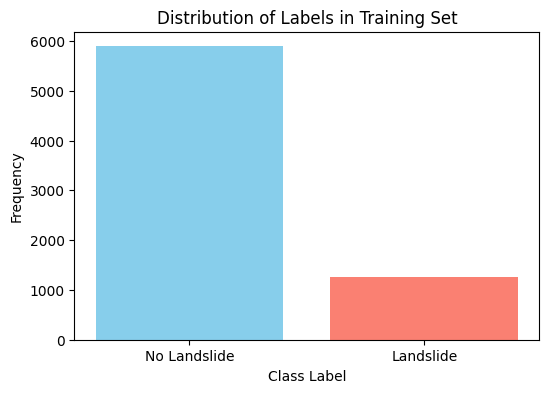

In [6]:
# Check distribution of labels
label_counts = full_train_df['label'].value_counts()
labels = ['No Landslide', 'Landslide']  # Map the labels 0 and 1 to descriptive names

plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()

### **Observation** <br>
The bar chart clearly shows that there is a significant class imbalance in the training data.
- The `No Landslide` (0) is the majority class with a frequency of about 6,000
- The `landslide` (1) is the minority class with a frequency of aproximately 1,200

### **IMPLICATIONS FOR THIS PROJECT**
- Due to the class imbalance using accuracy as a fundamental evaluation metric will lead to a flaw in our evaluation.This is cause a model can achieve over 80% accuracy while just always predicted "No Landslide".
- Therefore, the primary success metric for this project is the **F1-Score** as it measures the model's performance on the minority class  by forcing a balance between precision an recall. Thus a high F1-Score is only achievable by a model that skillfully handles this trade-off <br>

 **Techniques used.** <br>
To ensure the model learns the patterns of the minority class the following techniques were implemented:
- **Focal Loss function**- It dynamically adjusts the weight of each sample, forcing the model to focus its learning efforts on the "**hard**," misclassified examples, which are overwhelmingly part of the minority "Landslide" class. This prevents the easy majority class samples from dominating the training process.
- **Stratified K-Fold Cross-Validation**- It preserves the class distribution ratio within each fold, guaranteeing that every validation split is a representative sample of the overall dataset. This makes our final averaged OOF (Out-of-Fold) score a much more trustworthy measure of true model performance.
- **Oversampling of minority class** - The model will be feed batches with a 50/50 split of "Landslide" and "No Landslide" samples. To prevent the model from overfitting on the repeated landslide examples from this oversampling strategy, random **data augmentations**  are applied within the pipeline. This ensures that the model rarely sees the exact same image twice.
- **Threshold tuning** - The default threshold is usually 0.5 which is usually not the best for an imbalanced dataset. By tuning the threshold it finds the optimal value that best separates the two classes. This directly optimizes the F1-Score and leads to a performance boost

# 5. LOAD FULL TFRECORD DATASET INTO MEMORY

In [7]:
# LOAD FULL TFRECORD DATASET INTO MEMORY Load 

def load_full_dataset_from_tfrecord(tfrecord_path):
    """
    Parses the entire TFRecord file and returns its contents as NumPy arrays.
    """
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    
    # Use a modified parser that returns all relevant fields
    def _parse_for_loading(example_proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        label = tf.cast(parsed_features['label'], tf.int32)
        return image, label

    # Create the dataset and iterate through it to extract the data
    dataset = raw_dataset.map(_parse_for_loading)
    
    all_images = []
    all_labels = []
    print("Loading all data from TFRecord into memory... (This may take a moment)")
    for image, label in dataset:
        all_images.append(image.numpy())
        all_labels.append(label.numpy())
    
    print("Data loaded successfully.")
    return np.array(all_images), np.array(all_labels)

# Load the training data. 
X_full, y_full = load_full_dataset_from_tfrecord(TRAIN_TFRECORD_PATH)

print(f"\nShape of X_full (all images): {X_full.shape}")
print(f"Shape of y_full (all labels): {y_full.shape}")

Loading all data from TFRecord into memory... (This may take a moment)
Data loaded successfully.

Shape of X_full (all images): (7147, 64, 64, 12)
Shape of y_full (all labels): (7147,)


--- Displaying raw data samples for initial inspection... ---


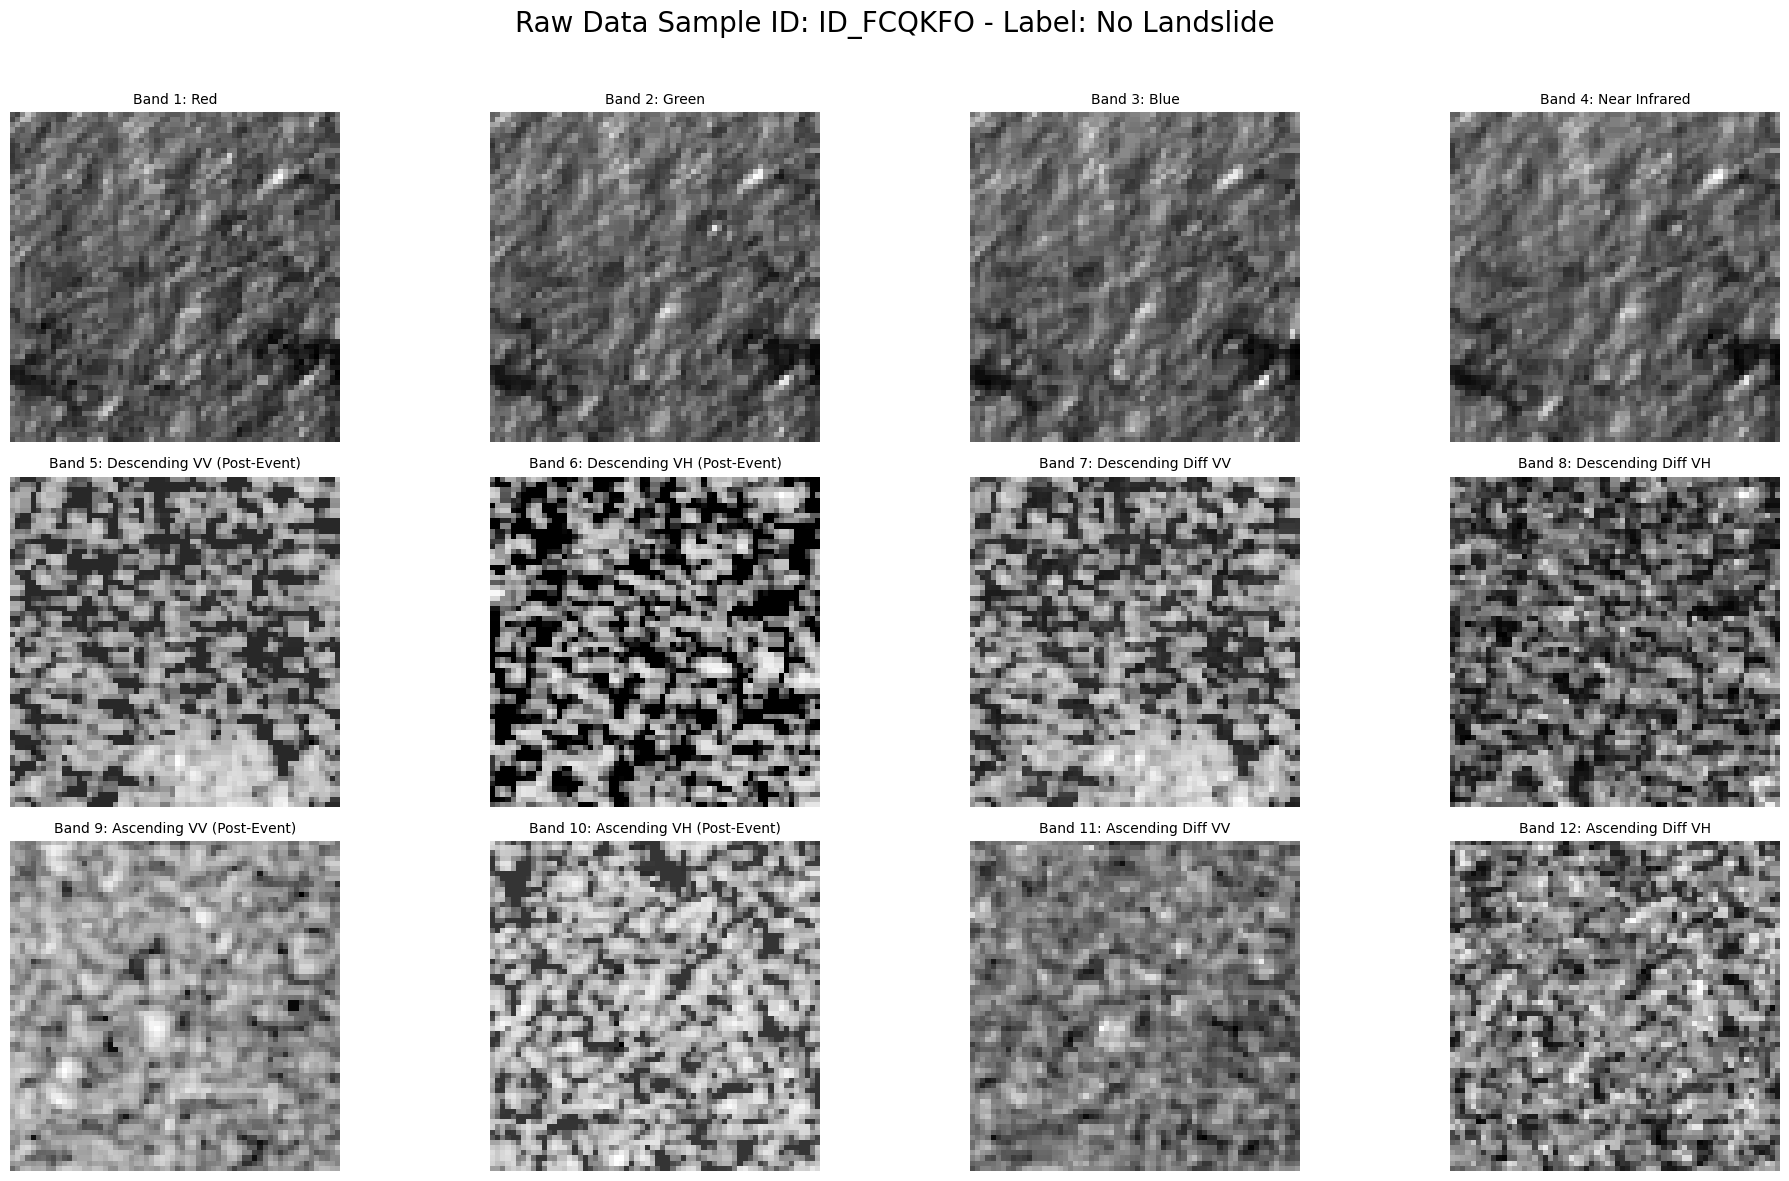

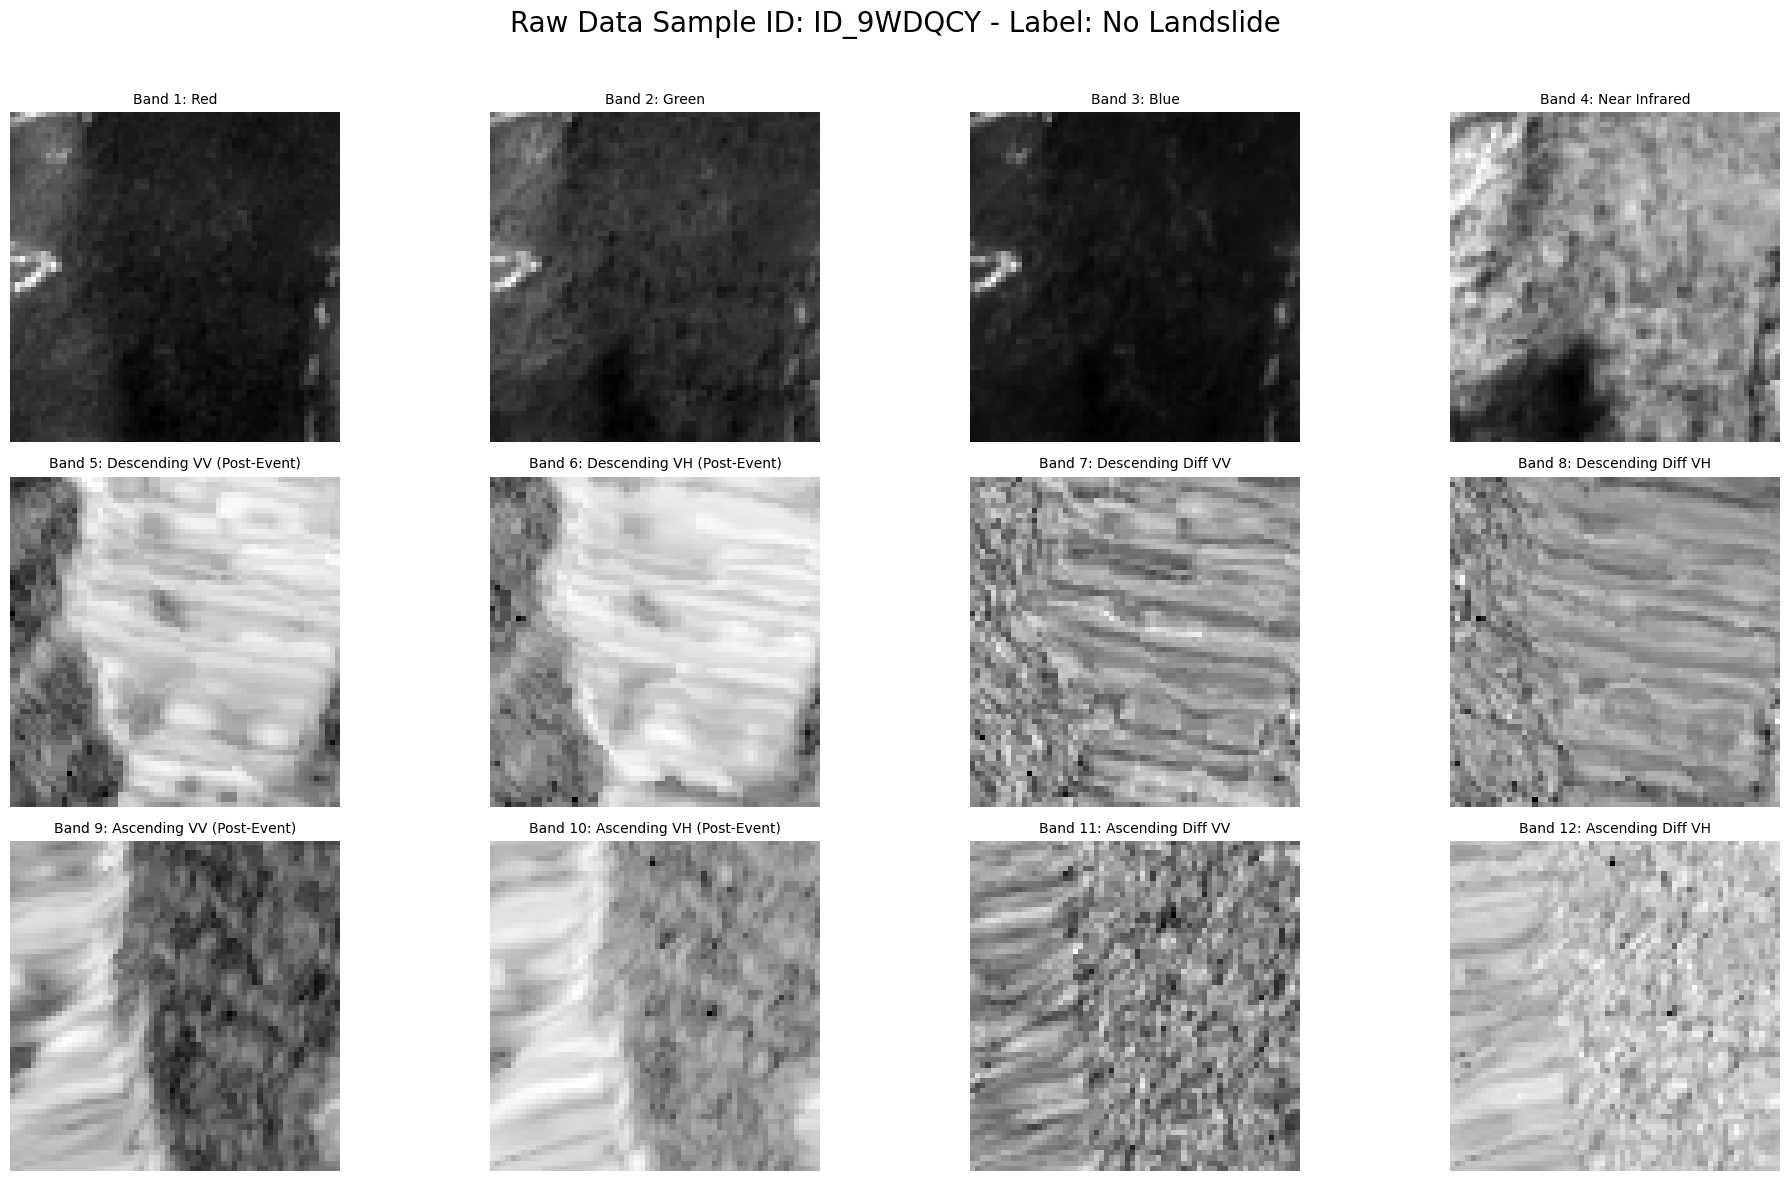

In [8]:
# INSPECTION: VISUALIZING A RAW DATA SAMPLE
print("--- Displaying raw data samples for initial inspection... ---")

# This local helper function is only used within this cell.
# It has no external dependencies.
def load_and_normalize_for_display(image_id, folder_path):
    """
    A simple, self-contained function to load one .npy file and normalize
    its bands to the 0-1 range, purely for visualization purposes.
    """
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    try:
        img = np.load(image_path)
    except FileNotFoundError:
        print(f"ERROR: Could not find image file at {image_path}")
        return None, None # Return None if the file doesn't exist

    # Normalize each band individually to the 0-1 range for clear plotting.
    # A small epsilon (1e-6) is added to prevent division by zero if a band is blank.
    min_vals = img.min(axis=(0, 1), keepdims=True)
    max_vals = img.max(axis=(0, 1), keepdims=True)
    img_normalized = (img - min_vals) / (max_vals - min_vals + 1e-6)
    
    # Get the corresponding label from the main DataFrame
    label = full_train_df[full_train_df['ID'] == image_id]['label'].values[0]
    
    return img_normalized, label

# --- Plot a Couple of Random Examples ---
# This only depends on variables defined at the top of the notebook.
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Post-Event)", "Descending VH (Post-Event)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Post-Event)", "Ascending VH (Post-Event)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Get two random IDs from the training dataframe
example_ids = full_train_df.sample(2)['ID'].values

for image_id in example_ids:
    # Use our simple, local function to get the data
    normalized_image, label_value = load_and_normalize_for_display(image_id, TRAIN_NPY_PATH)

    # Proceed only if the image was loaded successfully
    if normalized_image is not None:
        label_text = "Landslide" if label_value == 1 else "No Landslide"

        fig, axes = plt.subplots(3, 4, figsize=(20, 12))
        fig.suptitle(f"Raw Data Sample ID: {image_id} - Label: {label_text}", fontsize=20)

        for band in range(12):
            row = band // 4
            col = band % 4
            ax = axes[row, col]
            # Use a grayscale colormap to represent single-band intensity
            ax.imshow(normalized_image[:, :, band], cmap='gray')
            ax.set_title(f"Band {band + 1}: {band_descriptions[band]}", fontsize=10)
            ax.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

### **Observation**
- For the human eye it is extremely difficult to to identify a landslide from a non-landslide just by looking at these 12 bands individually. This diffuculty in visual interpretation is exactly the reason why a machine learning model is needed.
- Thus the success of this project does not depend on creating visually obvious features but on building a model capable of learning the subtle, multi-dimensional patterns that aren't apparent to the human eye

# **DATA PREPARATION**


- In this section, the raw data is transformed into a clean, structured and model-ready format. This will involve splitting the data for training and validating. 

In [9]:
# Train validation split
from sklearn.model_selection import train_test_split

print("--- Creating the master Train/Validation Split ---")

# Determine the indices for our working dataset (either full or a sample)
if Config.USE_FULL_DATASET:
    print("Using full dataset.")
    # The indices are simply all the indices from the full dataset
    working_indices = np.arange(len(full_train_df))
else:
    print(f"Creating a {Config.SAMPLE_FRACTION*100}% stratified subsample.")
    # Perform a stratified split on the LABELS to get a representative subsample of indices
    _, working_indices = train_test_split(
        np.arange(len(full_train_df)),
        test_size=Config.SAMPLE_FRACTION,
        shuffle=True,
        stratify=full_train_df['label'].values,
        random_state=Config.SEED
    )

print(f"Working with {len(working_indices)} total samples.")

# Split these indices into training and validation sets
train_indices, val_indices = train_test_split(
    working_indices,
    test_size=0.20,
    shuffle=True,
    # Stratify on the labels corresponding to our working indices
    stratify=full_train_df['label'].iloc[working_indices].values,
    random_state=Config.SEED
)

print(f"Split into {len(train_indices)} training samples and {len(val_indices)} validation samples.")

--- Creating the master Train/Validation Split ---
Using full dataset.
Working with 7147 total samples.
Split into 5717 training samples and 1430 validation samples.


## 3.1 STATISTICAL FEATURE ENGINEERING FOR TRADITIONAL MODELS

To create a strong baseline. we ;
- First prepare the data for traditional tree-based models like XGBoost and LightGBM. This will convert the raw image arrays into a tabular format by engineering statistical features.
- For each of the 12 original bands plus the engineered ones, the aggregate statistics like mean and standard deviation are calculated. By doing this we extract the important signal from the noisy spatial data into a set of tabular features

In [10]:
# STATISTICAL FEATURE ENGINEERING

def extract_additional_features(img_array):
    """
    Calculates derived indices like NDVI and NDWI from a multi-band image array.
    This is a preliminary step before aggregation.
    """
    # Bands are 0-indexed. Bands 1-4 are Red, Green, Blue, NIR.
    red = img_array[..., 0]
    green = img_array[..., 1]
    nir = img_array[..., 3]
    
    epsilon = 1e-7 # To prevent division by zero

    # NDVI = (NIR - Red) / (NIR + Red)
    ndvi = (nir - red) / (nir + red + epsilon)

    # NDWI = (Green - NIR) / (Green + NIR)
    ndwi = (green - nir) / (green + nir + epsilon)
    
    # Expand dims to stack them as new channels
    ndvi = ndvi[..., np.newaxis]
    ndwi = ndwi[..., np.newaxis]

    # Concatenate the new features to the original image channels
    features = np.concatenate([img_array, ndvi, ndwi], axis=-1)
    return features

print("Calculating derived indices (like NDVI) for training data...")
X_train_with_indices = extract_additional_features(X_train_npy)
print("Calculating derived indices (like NDVI) for test data...")
X_test_with_indices = extract_additional_features(X_test_npy)

print(f"\nNew shape of training data with indices: {X_train_with_indices.shape}")


def create_statistical_features_df(df, image_features_array):
    """
    Takes an image array and calculates aggregate statistics for each channel,
    returning a tabular DataFrame.
    """
    stats_df = df.copy()
    
    # Original bands 1 to 12
    band_names = [f'band{i+1}' for i in range(12)]
    # Add new derived indices
    band_names.extend(['ndvi', 'ndwi'])

    print(f"\nGenerating statistical features for {len(stats_df)} samples...")
    
    for i, name in enumerate(band_names):
        channel_data = image_features_array[:, :, :, i]
        
        stats_df[f'{name}_mean'] = channel_data.mean(axis=(1, 2))
        stats_df[f'{name}_std']  = channel_data.std(axis=(1, 2))
        stats_df[f'{name}_min']  = channel_data.min(axis=(1, 2))
        stats_df[f'{name}_max']  = channel_data.max(axis=(1, 2))
        stats_df[f'{name}_kurt'] = kurtosis(channel_data, axis=(1, 2), fisher=True)
        stats_df[f'{name}_skew'] = skew(channel_data, axis=(1, 2))

    print("...statistical features created successfully.")
    return stats_df

# Create the final tabular DataFrames for our ML models
training_df_stats = create_statistical_features_df(full_train_df, X_train_with_indices)
testing_df_stats = create_statistical_features_df(test_df, X_test_with_indices)

print("\nPreview of the first 5 rows of the new training DataFrame:")
display(training_df_stats.head())

Calculating derived indices (like NDVI) for training data...
Calculating derived indices (like NDVI) for test data...

New shape of training data with indices: (7147, 64, 64, 14)

Generating statistical features for 7147 samples...
...statistical features created successfully.

Generating statistical features for 5398 samples...
...statistical features created successfully.

Preview of the first 5 rows of the new training DataFrame:


,ID,label,band1_mean,band1_std,band1_min,band1_max,band1_kurt,band1_skew,band2_mean,band2_std,...,ndvi_min,ndvi_max,ndvi_kurt,ndvi_skew,ndwi_mean,ndwi_std,ndwi_min,ndwi_max,ndwi_kurt,ndwi_skew
0,ID_HUD1ST,1,1569.305908,189.202896,1286.0,2786.0,5.343067,1.930577,1751.834229,211.081497,...,0.051762,0.578009,2.067133,-1.451810,-0.402533,0.076766,-0.513693,-0.031306,2.505169,1.581910
1,ID_KGE2HY,1,1575.859131,233.255280,1309.0,2988.0,4.867769,2.048139,1750.446289,234.474838,...,-0.044847,0.570146,1.214721,-1.396452,-0.348885,0.112248,-0.505679,0.074906,1.269663,1.417164
2,ID_VHV9BL,1,1396.610352,811.493347,939.0,9040.0,32.241085,5.189392,1528.299805,915.895203,...,-0.068752,0.723393,-0.927661,-0.325244,-0.337329,0.150220,-1.000000,0.041941,-0.857999,0.307474
3,ID_ZT0VEJ,0,1589.653320,366.122314,1300.0,4244.0,12.224893,3.234218,1746.923828,340.235382,...,0.118875,0.599184,1.487577,-1.212002,-0.397269,0.069903,-0.539870,-0.107788,1.487541,1.217311
4,ID_5NFXVY,0,1456.682617,120.247475,1317.0,2064.0,5.837114,2.370760,1595.559570,126.943199,...,0.090818,0.531350,8.192582,-2.779035,-0.385836,0.070818,-0.481177,-0.061585,8.969378,2.962669


## 3.2 Feature selection 
- The feature engineering process produced a set of 84 statistical features. However not all of them may be predictive. There includes irrelevant and redundant features which add noise.
- To address this a model-based feature selection is performed. An initial XGBoost classifier is used to evaluate the importance of all 84 features and select only the most impactful half.
- The next step is then to establish a performance baseline by training a standard xgboost model and determining the baseline F1-score. This will serve as a benchmark that our more complex , fine-tuned models must outperform

In [11]:
# ML MODELING 1: FEATURE SELECTION & BASELINE XGBOOST

# Prepare data for scikit-learn models
# Drop non-feature columns
X_df = training_df_stats.drop(columns=['ID', 'label'])
y_df = training_df_stats['label']


#  Feature Selection using a model-based approach
print("Performing feature selection...")
feature_selector = SelectFromModel(XGBClassifier(random_state=Config.SEED), threshold='median')
feature_selector.fit(X_df, y_df)

# Get the names of the selected features
selected_feature_names = X_df.columns[feature_selector.get_support()]
X_selected = X_df[selected_feature_names]

print(f"...selected {len(selected_feature_names)} features out of {len(X_df.columns)}.")
print("-" * 30)


# Define Cross-Validation function 
def cross_validate_model(model, X, y, n_splits=5):
    """Performs stratified K-Fold cross-validation and returns the mean F1 score."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=Config.SEED)
    f1_scores = []
    
    print(f"Running {n_splits}-Fold Cross-Validation for {model.__class__.__name__}...")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        
        # the best threshold on the validation set for this fold
        y_pred_probs = model.predict_proba(X_val)[:, 1]
        thresholds = np.linspace(0.2, 0.8, 31) # Search a range of thresholds
        scores = [f1_score(y_val, (y_pred_probs >= thresh).astype(int)) for thresh in thresholds]
        
        best_threshold = thresholds[np.argmax(scores)]
        y_pred = (y_pred_probs > best_threshold).astype(int)
        
        fold_f1 = f1_score(y_val, y_pred)
        f1_scores.append(fold_f1)
        print(f"Fold {fold+1} F1: {fold_f1:.4f} (Best Threshold: {best_threshold:.2f})")
    
    mean_f1 = np.mean(f1_scores)
    print(f"\n=> Average CV F1 Score: {mean_f1:.4f}")
    print("-" * 30)
    return mean_f1


#  Train and evaluate a baseline XGBoost model
baseline_xgb = XGBClassifier(random_state=Config.SEED)
baseline_xgb_score = cross_validate_model(baseline_xgb, X_selected, y_df)

Performing feature selection...
...selected 42 features out of 84.
------------------------------
Running 5-Fold Cross-Validation for XGBClassifier...
Fold 1 F1: 0.8383 (Best Threshold: 0.40)
Fold 2 F1: 0.8446 (Best Threshold: 0.34)
Fold 3 F1: 0.8732 (Best Threshold: 0.36)
Fold 4 F1: 0.8885 (Best Threshold: 0.32)
Fold 5 F1: 0.8446 (Best Threshold: 0.36)

=> Average CV F1 Score: 0.8579
------------------------------


## 4. MODELING (TRADITIONAL ML MODELS)


### 4.1 Hyperparameter Optimization for XGBoost

- The baseline model was trained using default hyperparameters of the xgboost library. To ensure it achieves its true potential hyperparameter tuning is performed.
- Oputna, is used for this task. Unlike grid or random search optuna learns from past trials to intelligently and efficiently explore the hyperparameter space.
- We define an object and run the search for 50 trials to identify the best-performing set of parameters

In [12]:
# HYPERPARAMETER TUNING FOR XGBOOST WITH OPTUNA

# A simple train/validation split for Optuna to efficiently evaluate trials.
# Will use the full cross-validation function later to verify the final best model.
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_selected, y_df, test_size=0.2, stratify=y_df, random_state=Config.SEED
)

def objective(trial):
    """
    The function that Optuna will call to evaluate a set of hyperparameters.
    """
    # Define the search space for the hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "random_state": Config.SEED,
    }

    # Train a model with the suggested parameters
    model = XGBClassifier(**params)
    model.fit(X_train_opt, y_train_opt, eval_set=[(X_val_opt, y_val_opt)], verbose=False, early_stopping_rounds=10)

    # Evaluate the model
    preds = model.predict(X_val_opt)
    f1 = f1_score(y_val_opt, preds)

    return f1

# Run the Optuna study
print("Starting Optuna hyperparameter search for XGBoost...")
# We keep the logging minimal for a cleaner notebook
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create a study object and specify we want to maximize the F1 score
xgb_study = optuna.create_study(direction="maximize", study_name="XGBoost Optimization")
xgb_study.optimize(objective, n_trials=50) # n_trials can be increased for a more thorough search

print("...Optuna search complete.")
print(f"\nBest F1 Score found: {xgb_study.best_value:.4f}")
print("Best Hyperparameters:")
print(xgb_study.best_params)
print("-" * 30)

Starting Optuna hyperparameter search for XGBoost...


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_sto

...Optuna search complete.

Best F1 Score found: 0.8758
Best Hyperparameters:
{'max_depth': 9, 'learning_rate': 0.17838792000062942, 'subsample': 0.9982968362626319, 'colsample_bytree': 0.7679092408249147, 'min_child_weight': 10, 'gamma': 2.03075836100528, 'reg_lambda': 0.003207906626880176, 'reg_alpha': 5.191088107455459e-06}
------------------------------


### 4.2 Validating the Tuned XGBoost Model
- After identifying the optimal hyperparameters with Optuna, the next step is to validate their effectiveness. A new  XGBoost model with these best parameters is instantiated and re-ran.
  
- LightGBM is introduced here as a challenger to ensure we are using the best possible tabular model,

- A direct, fair comparison between the two is carried out to determine the best model for our statistically engineered features.

In [13]:
# TRAINING OPTIMIZED XGBOOST & LIGHTGBM

# Train and Evaluate the Tuned XGBoost Model
print("--- Training Final XGBoost Model with Best Parameters ---")

# Create a new XGBClassifier instance with the best hyperparameters found by Optuna
best_xgb_model = XGBClassifier(**xgb_study.best_params, random_state=Config.SEED)

# Evaluate this optimized model using our robust cross-validation function
xgb_optimized_score = cross_validate_model(best_xgb_model, X_selected, y_df)

# Train and Evaluate a Baseline LightGBM Model  as it's often faster and performs well
print("\n--- Training Baseline LightGBM Model ---")
baseline_lgbm = LGBMClassifier(random_state=Config.SEED)
lgbm_baseline_score = cross_validate_model(baseline_lgbm, X_selected, y_df)

--- Training Final XGBoost Model with Best Parameters ---
Running 5-Fold Cross-Validation for XGBClassifier...
Fold 1 F1: 0.8465 (Best Threshold: 0.38)
Fold 2 F1: 0.8242 (Best Threshold: 0.38)
Fold 3 F1: 0.8450 (Best Threshold: 0.28)
Fold 4 F1: 0.8638 (Best Threshold: 0.44)
Fold 5 F1: 0.8410 (Best Threshold: 0.40)

=> Average CV F1 Score: 0.8441
------------------------------

--- Training Baseline LightGBM Model ---
Running 5-Fold Cross-Validation for LGBMClassifier...
[LightGBM] [Info] Number of positive: 1004, number of negative: 4713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 5717, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175617 -> initscore=-1.546333
[LightGBM] [Info] Start training from score -1.546333
Fold 1 F1: 0.8525 (Best Threshold

***Analysing the results:***
- Tuned XGBoost: Achieved an average F1 score of 0.8517.
- Baseline LightGBM: Achieved an average F1 score of 0.8610. <br>

***Conclusion:*** <br>
The LightGBM model, even with its default hyperparameters, slightly outperformed the carefully tuned XGBoost model.

- This finding shows us that sometimes a different algorithm can be more powerful than extensively tuning another one

## SHARP FEATURE IMPORTANCE PLOT FOR LIGHTGBM
- This plot will provide a clear and quantitative ranking of the features that LightGBM model found most impactful for detecting landsldes

--- Generating SHAP values for the champion LightGBM model ---
[LightGBM] [Info] Number of positive: 1255, number of negative: 5892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 7147, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175598 -> initscore=-1.546460
[LightGBM] [Info] Start training from score -1.546460
Calculating SHAP values... (This may take a moment)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Generating SHAP summary plot...


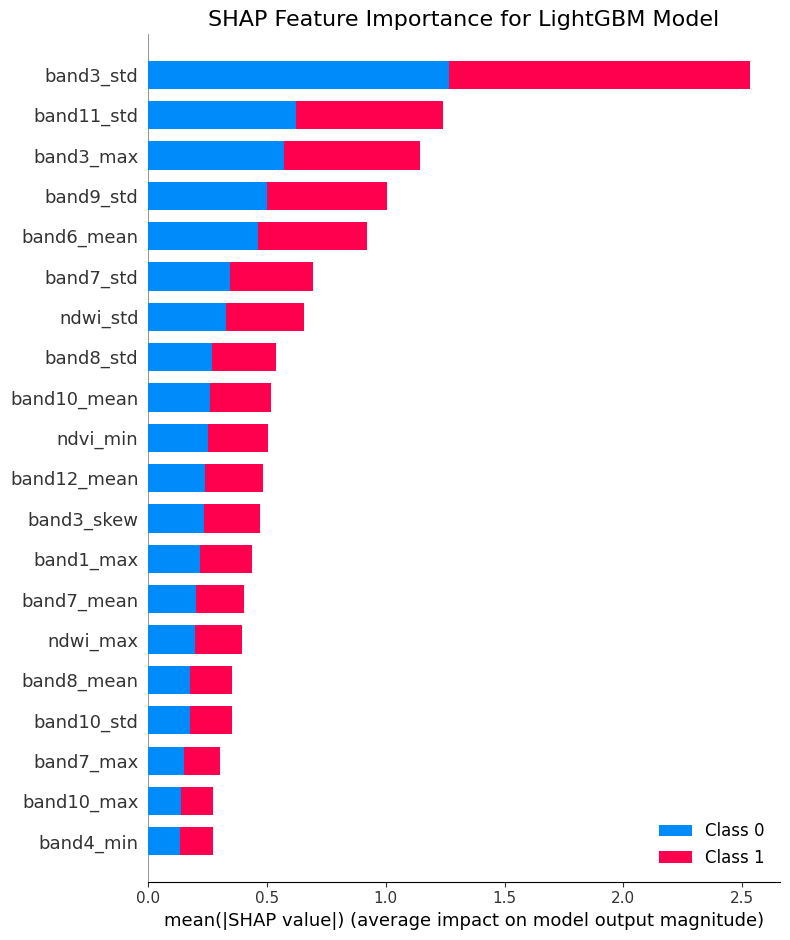


--- SHAP Analysis Complete ---
The plot above shows the mean absolute SHAP value for each feature, indicating its overall importance.


In [14]:
# MODEL INTERPRETABILITY WITH SHAP FOR LIGHTGBM

print("--- Generating SHAP values for the champion LightGBM model ---")

# Instantiate a new LightGBM model with default parameters, as this was our champio
final_lgbm_model_for_shap = lgb.LGBMClassifier(random_state=Config.SEED)
final_lgbm_model_for_shap.fit(X_selected, y_df)

# The same TreeExplainer can be used for LightGBM models.
explainer = shap.TreeExplainer(final_lgbm_model_for_shap)

# Calculate SHAP values 
print("Calculating SHAP values... (This may take a moment)")
shap_values = explainer.shap_values(X_selected)

# Create the SHAP summary plot 
print("Generating SHAP summary plot...")
plt.title("SHAP Feature Importance for LightGBM Model", size=16)
shap.summary_plot(shap_values, X_selected, plot_type="bar", show=False)
plt.show()

print("\n--- SHAP Analysis Complete ---")
print("The plot above shows the mean absolute SHAP value for each feature, indicating its overall importance.")

### ***Observation***

- The most important features are overwhelmingly **standard deviation** metrics. Five of the top seven features (band3_std, band11_std, band9_std, band7_std, ndwi_std) are measures of pixel variance. This is a clear insight: the model has learned that the variability or inconsistency of pixel values within a band is a stronger predictor.
- Bands band11_std and band7_std which deal with "**Change-Detection**" are ranked high confirming their importance. This tells us that the change in the radar signal over time is a highly informative input for the model.

- **Conclusion:** This proves that the model is not a black box and has learned to make it's prediction based on a logical pattern

# FEATURE ENGINEERING CELL

In [15]:
import numpy as np

# DEFINE THE STATS CALCULATION FUNCTION
def calculate_global_stats(X_data):
    """
    Iterates through the training dataset to find the global min and max 
    values for all potential engineered features.
    
    Args:
        X_data: A NumPy array of the training images.

    Returns:
        A dictionary containing the global min/max for each feature.
    """
    print(f"Calculating global statistics on {len(X_data)} training samples...")
    
    # Pre-allocate full NumPy arrays instead of using Python lists 
    num_samples, height, width, _ = X_data.shape
    all_desc_mag = np.zeros((num_samples, height, width), dtype=np.float32)
    all_asc_mag = np.zeros((num_samples, height, width), dtype=np.float32)
    all_desc_ratio_diff = np.zeros((num_samples, height, width), dtype=np.float32)
    all_asc_ratio_diff = np.zeros((num_samples, height, width), dtype=np.float32)
    all_ndvi_diff = np.zeros((num_samples, height, width), dtype=np.float32)
    all_ndvi_post = np.zeros((num_samples, height, width), dtype=np.float32)
    all_savi_diff = np.zeros((num_samples, height, width), dtype=np.float32)
    all_ndwi_diff = np.zeros((num_samples, height, width), dtype=np.float32)
    
    # --- END OF FIX ---
    
    batch_size = 256 
    for i in range(0, num_samples, batch_size):
        # Define the slice for the current batch
        start_idx, end_idx = i, i + batch_size
        batch_images = X_data[start_idx : end_idx]

# ==============================================================================
#       # Group 2(a & b) Descending & Ascending Change Magnitude
# ==============================================================================
        # Descending Change Magnitude
        desc_diff_vv = batch_images[..., 6]
        desc_diff_vh = batch_images[..., 7]
        desc_mag = np.sqrt(np.square(desc_diff_vv) + np.square(desc_diff_vh))
        all_desc_mag[start_idx : end_idx] = desc_mag # FIX: Fill slice
        
        # Ascending Change Magnitude
        asc_diff_vv = batch_images[..., 10]
        asc_diff_vh = batch_images[..., 11]
        asc_mag = np.sqrt(np.square(asc_diff_vv) + np.square(asc_diff_vh))
        all_asc_mag[start_idx : end_idx] = asc_mag # FIX: Fill slice

# ==============================================================================
#       # Group 2(a) Descending VV Ratio
# ==============================================================================
        desc_vv_post = batch_images[..., 4].astype(np.float32)
        desc_vh_post = batch_images[..., 5].astype(np.float32)
        desc_diff_vv = batch_images[..., 6].astype(np.float32)
        desc_diff_vh = batch_images[..., 7].astype(np.float32)
        desc_vv_pre = desc_vv_post - desc_diff_vv
        desc_vh_pre = desc_vh_post - desc_diff_vh
        denominator_floor = 1.0 
        ratio_post_desc = desc_vv_post / np.maximum(desc_vh_post, denominator_floor)
        ratio_pre_desc  = desc_vv_pre  / np.maximum(desc_vh_pre,  denominator_floor)
        desc_ratio_diff = ratio_post_desc - ratio_pre_desc
        all_desc_ratio_diff[start_idx : end_idx] = desc_ratio_diff # FIX: Fill slice
        
# ==============================================================================
#       # Group 2(b) Ascending VV Ratio 
# ==============================================================================
        asc_vv_post = batch_images[..., 8].astype(np.float32)
        asc_vh_post = batch_images[..., 9].astype(np.float32)
        asc_diff_vv = batch_images[..., 10].astype(np.float32)
        asc_diff_vh = batch_images[..., 11].astype(np.float32)
        asc_vv_pre = asc_vv_post - asc_diff_vv
        asc_vh_pre = asc_vh_post - asc_diff_vh
        ratio_post_asc = asc_vv_post / np.maximum(asc_vh_post, denominator_floor)
        ratio_pre_asc  = asc_vv_pre  / np.maximum(asc_vh_pre,  denominator_floor)
        asc_ratio_diff = ratio_post_asc - ratio_pre_asc
        all_asc_ratio_diff[start_idx : end_idx] = asc_ratio_diff # FIX: Fill slice
      
# ==============================================================================
#       # Group 3 (a)Calculate NDVI Difference
# ==============================================================================
        red_post = batch_images[..., 0]
        nir_post = batch_images[..., 3]
        desc_diff_vv = batch_images[..., 6]
        desc_diff_vh = batch_images[..., 7]
        proxy_optical_change = (desc_diff_vv + desc_diff_vh) / 2.0
        red_pre = red_post - proxy_optical_change
        nir_pre = nir_post - proxy_optical_change
        epsilon = 1e-7
        ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)

        
        ndvi_pre  = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
        ndvi_diff = ndvi_post - ndvi_pre
        all_ndvi_diff[start_idx : end_idx] = ndvi_diff # FIX: Fill slice
        all_ndvi_post[start_idx : end_idx] = ndvi_post
# ==============================================================================
#       # Group 3 (b) Calculate NDVI Difference
# ==============================================================================
        L = 0.5 # Standard soil brightness correction factor
        
        savi_post = ((nir_post - red_post) / (nir_post + red_post + L)) * (1.0 + L)
        savi_pre  = ((nir_pre - red_pre) / (nir_pre + red_pre + L)) * (1.0 + L)
        
        savi_diff = savi_post - savi_pre
        all_savi_diff[start_idx : end_idx] = savi_diff
# ==============================================================================
#       # Group 4 Calculate NDWI Difference 
# ==============================================================================
        # Isolate the necessary optical bands
        green_post = batch_images[..., 1]  
        nir_post = batch_images[..., 3]    
        # `proxy_optical_change` and `nir_pre` are already calculated from the NDVI block

        green_pre = green_post - proxy_optical_change
        
        # Calculate NDWI_post and NDWI_pre
        epsilon = 1e-7
        ndwi_post = (green_post - nir_post) / (green_post + nir_post + epsilon)
        ndwi_pre  = (green_pre - nir_pre) / (green_pre + nir_pre + epsilon)
        
        # Calculate the final difference feature
        ndwi_diff = ndwi_post - ndwi_pre
        all_ndwi_diff[start_idx : end_idx] = ndwi_diff

    
    # Calculate and store the final min/max values
    stats = {
        'desc_mag_min': np.min(all_desc_mag),
        'desc_mag_max': np.max(all_desc_mag),
        'asc_mag_min': np.min(all_asc_mag),
        'asc_mag_max': np.max(all_asc_mag),
        'desc_ratio_diff_min': np.min(all_desc_ratio_diff),
        'desc_ratio_diff_max': np.max(all_desc_ratio_diff),
        'asc_ratio_diff_min': np.min(all_asc_ratio_diff),
        'asc_ratio_diff_max': np.max(all_asc_ratio_diff),
        'ndvi_diff_min': np.min(all_ndvi_diff),
        'ndvi_diff_max': np.max(all_ndvi_diff),
        'ndvi_post_min': np.min(all_ndvi_post),
        'ndvi_post_max': np.max(all_ndvi_post),
        'savi_diff_min': np.min(all_savi_diff),
        'savi_diff_max': np.max(all_savi_diff),
        'ndwi_diff_min': np.min(all_ndwi_diff),
        'ndwi_diff_max': np.max(all_ndwi_diff),
    }
    
    print("Global statistics calculation complete.")
    return stats

# --- 2. EXECUTE THE CALCULATION (This is unchanged) ---
print("Preparing data for statistics calculation...")
X_train_for_stats = X_full[train_indices]
global_stats = calculate_global_stats(X_train_for_stats)
print("\n Global Statistics ")
print(global_stats)

Preparing data for statistics calculation...
Calculating global statistics on 5717 training samples...
Global statistics calculation complete.

 Global Statistics 
{'desc_mag_min': 0.00041178806, 'desc_mag_max': 45.94748, 'asc_mag_min': 4.8958573e-05, 'asc_mag_max': 46.284046, 'desc_ratio_diff_min': -41.327717, 'desc_ratio_diff_max': 26.20918, 'asc_ratio_diff_min': -35.428696, 'asc_ratio_diff_max': 35.044502, 'ndvi_diff_min': -0.03388673, 'ndvi_diff_max': 0.3538921, 'ndvi_post_min': -1.0, 'ndvi_post_max': 1.0, 'savi_diff_min': -0.05079913, 'savi_diff_max': 0.26748133, 'ndwi_diff_min': -0.3538921, 'ndwi_diff_max': 0.039041877}


In [16]:
# FEATURE ENGINEERING FUNCTION

@tf.function
def engineer_features(image, stats):
    """
    Applies feature engineering and uses pre-computed global stats for normalization.
    """
    # Define epsilon for safe division within the TensorFlow graph.
    epsilon = K.epsilon() 
    
    # Feature: Descending Change Magnitude ---
    desc_diff_vv = image[..., 6]
    desc_diff_vh = image[..., 7]
    desc_mag = tf.sqrt(tf.square(desc_diff_vv) + tf.square(desc_diff_vh) + K.epsilon())
    
    # Global Normalization
    desc_mag_norm = (desc_mag - stats['desc_mag_min']) / (stats['desc_mag_max'] - stats['desc_mag_min'] + K.epsilon())
    desc_mag_norm = tf.expand_dims(desc_mag_norm, axis=-1)

    # Feature: Ascending Change Magnitude 
    asc_diff_vv = image[..., 10]
    asc_diff_vh = image[..., 11]
    asc_mag = tf.sqrt(tf.square(asc_diff_vv) + tf.square(asc_diff_vh) + K.epsilon())

    # Global Normalization
    asc_mag_norm = (asc_mag - stats['asc_mag_min']) / (stats['asc_mag_max'] - stats['asc_mag_min'] + K.epsilon())
    asc_mag_norm = tf.expand_dims(asc_mag_norm, axis=-1)

# ==============================================================================
#       # Group 2(a) Descending VV Ratio
# ==============================================================================
    # --- NEW: Add Descending Ratio Difference Feature ---
    desc_vv_post = image[..., 4]
    desc_vh_post = image[..., 5]
    desc_diff_vv = image[..., 6]
    desc_diff_vh = image[..., 7]
    
    desc_vv_pre = desc_vv_post - desc_diff_vv
    desc_vh_pre = desc_vh_post - desc_diff_vh
    denominator_floor = tf.constant(1.0, dtype=tf.float32)
    ratio_post = desc_vv_post / tf.maximum(desc_vh_post, denominator_floor)
    ratio_pre  = desc_vv_pre  / tf.maximum(desc_vh_pre,  denominator_floor)
    desc_ratio_diff = ratio_post - ratio_pre
    
    # Global Normalization
    desc_ratio_diff_norm = (desc_ratio_diff - stats['desc_ratio_diff_min']) / (stats['desc_ratio_diff_max'] - stats['desc_ratio_diff_min'] + epsilon)
    desc_ratio_diff_norm = tf.expand_dims(desc_ratio_diff_norm, axis=-1)

# ==============================================================================
#       # Group 2(B) Descending VV Ratio
# ==============================================================================
    # Ascending Ratio Difference Feature 
    asc_vv_post = image[..., 8]
    asc_vh_post = image[..., 9]
    asc_diff_vv = image[..., 10]
    asc_diff_vh = image[..., 11]
    asc_vv_pre = asc_vv_post - asc_diff_vv
    asc_vh_pre = asc_vh_post - asc_diff_vh
    denominator_floor = tf.constant(1.0, dtype=tf.float32)
    ratio_post_asc = asc_vv_post / tf.maximum(asc_vh_post, denominator_floor)
    ratio_pre_asc  = asc_vv_pre  / tf.maximum(asc_vh_pre,  denominator_floor)
    
    asc_ratio_diff = ratio_post_asc - ratio_pre_asc
    asc_ratio_diff_norm = (asc_ratio_diff - stats['asc_ratio_diff_min']) / (stats['asc_ratio_diff_max'] - stats['asc_ratio_diff_min'] + K.epsilon())
    asc_ratio_diff_norm = tf.expand_dims(asc_ratio_diff_norm, axis=-1)

# ==============================================================================
#       # Group 3 Calculate NDVI Difference
# ==============================================================================
        #  Isolate the necessary optical and SAR bands
    red_post = image[..., 0]  
    nir_post = image[..., 3]  
    desc_diff_vv = image[..., 6] 
    desc_diff_vh = image[..., 7] 

    # Create the Proxy Optical Change from SAR data
    proxy_optical_change = (desc_diff_vv + desc_diff_vh) / 2.0
    # Reconstruct the pre-event optical bands (our hypothesis)
    red_pre = red_post - proxy_optical_change
    nir_pre = nir_post - proxy_optical_change
    
    # Calculate NDVI_post and NDVI_pre (with epsilon)
    epsilon = 1e-7
    ndvi_post = (nir_post - red_post) / (nir_post + red_post + epsilon)
    ndvi_pre  = (nir_pre - red_pre) / (nir_pre + red_pre + epsilon)
    
    # Calculate the final difference feature
    ndvi_diff = ndvi_post - ndvi_pre
    # Global Normalization
    ndvi_diff_norm = (ndvi_diff - stats['ndvi_diff_min']) / (stats['ndvi_diff_max'] - stats['ndvi_diff_min'] + epsilon)
    ndvi_diff_norm = tf.expand_dims(ndvi_diff_norm, axis=-1)

     
    ndvi_post_norm = (ndvi_post - stats['ndvi_post_min']) / (stats['ndvi_post_max'] - stats['ndvi_post_min'] + epsilon)
    ndvi_post_norm = tf.expand_dims(ndvi_post_norm, axis=-1)
# ==============================================================================
#      Group 3 (b) Calculate SAVI Difference
# ==============================================================================
    L = tf.constant(0.5, dtype=tf.float32)

    savi_post = ((nir_post - red_post) / (nir_post + red_post + L)) * (1.0 + L)
    savi_pre  = ((nir_pre - red_pre) / (nir_pre + red_pre + L)) * (1.0 + L)
    
    savi_diff = savi_post - savi_pre
    
    # Global Normalization
    savi_diff_norm = (savi_diff - stats['savi_diff_min']) / (stats['savi_diff_max'] - stats['savi_diff_min'] + epsilon)
    savi_diff_norm = tf.expand_dims(savi_diff_norm, axis=-1)

# ==============================================================================
#       Group 4 Calculate NDVI Difference
# ==============================================================================
    # `proxy_optical_change` and `nir_pre` are available from the NDVI block
    green_post = image[..., 1]
    nir_post = image[..., 3]
    
    green_pre = green_post - proxy_optical_change
    
    ndwi_post = (green_post - nir_post) / (green_post + nir_post + epsilon)
    ndwi_pre  = (green_pre - nir_pre) / (green_pre + nir_pre + epsilon)
    
    ndwi_diff = ndwi_post - ndwi_pre
    
    # Global Normalization
    ndwi_diff_norm = (ndwi_diff - stats['ndwi_diff_min']) / (stats['ndwi_diff_max'] - stats['ndwi_diff_min'] + epsilon)
    ndwi_diff_norm = tf.expand_dims(ndwi_diff_norm, axis=-1)
   
    # original_bands_scaled = image / 255.0
    # Concatenate Features 
    final_image = image
    #final_image = tf.concat([final_image, desc_mag_norm], axis=-1)
    final_image = tf.concat([final_image, asc_mag_norm], axis=-1)
    #final_image = tf.concat([final_image, desc_ratio_diff_norm], axis=-1)
    #final_image = tf.concat([final_image, asc_ratio_diff_norm], axis=-1)
    final_image = tf.concat([final_image, ndvi_diff_norm], axis=-1)
    # final_image = tf.concat([final_image, ndvi_post_norm], axis=-1) # New model to test
    # final_image = tf.concat([final_image, savi_diff_norm], axis=-1)
    # final_image = tf.concat([final_image, ndwi_diff_norm], axis=-1)
    
    return final_image

print("Engineer_features` function defined.")

Engineer_features` function defined.


# 6. Define the High-Performance tf.data Pipeline Function

1. A Reusable Factory: We now have one function, build_dataset, that can create a dataset for training, validation, or testing, just by changing the arguments.
2. CPU/GPU Division of Labor: It isolates the single non-TensorFlow operation (np.load) into a tf.py_function and ensures all the heavy mathematical work (resizing, NDVI, augmentations) is defined with tf.* operations, allowing them to be offloaded to the GPU.
3. Performance Optimization: It includes .shuffle(), .batch(), and the critical .prefetch() methods to ensure a smooth, fast, and continuous stream of data to the accelerator.

In [17]:

def get_parse_function(stats):
    """
    This is the original, high-performing factory function.
    """
    stats_tensor = {k: tf.constant(v, dtype=tf.float32) for k, v in stats.items()}
    
    @tf.function
    def parse_tfrecord_function(example_proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64),
        }
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
        
        # This line now works, as it expects ONE tensor and receives ONE tensor.
        image = engineer_features(image, stats_tensor)
        
        # Resize the single, final tensor.
        image = tf.image.resize(image, Config.TARGET_SIZE, method='bilinear')
        
        # Apply the coarse scaling that was so effective.
        image = image / 255.0
        
        image = tf.ensure_shape(image, [*Config.TARGET_SIZE, Config.N_CHANNELS])
        label = tf.cast(parsed_features['label'], tf.float32)
        label = tf.reshape(label, (1,))
        
        return image, label
        
    return parse_tfrecord_function

# This line MUST be at the end of the cell to create the global variable
parse_function_with_stats = get_parse_function(global_stats)

print("Parser function reverted to original high-performing version and created successfully.")

Parser function reverted to original high-performing version and created successfully.


### Create the Final Training and Validation Datasets
Call the build_dataset function we just created. This cell will produce the final, optimized tf.data.Dataset objects that we will feed directly into our model for training.

Here, we will also implement the logic for a balanced training set by oversampling the minority class (landslides), but we will do it using the efficient tf.data methodology.

What this cell accomplishes:

1. Validation Dataset: It creates a standard validation set where the data is simply loaded, resized, and batched. No augmentation or shuffling is applied, giving us a true measure of performance.

2. Balanced Training Dataset: It cleverly creates two separate datasets (pos_ds and neg_ds), then uses sample_from_datasets to pull from each with 50/50 probability. This is the efficient tf.data equivalent of the BalancedDataGenerator you had before.

3. Calculates steps_per_epoch: This is a crucial number we will need to give to model.fit() later, as our new training dataset is technically infinite.

4. Sanity Check: It takes one batch from the training set and prints its shape and labels, allowing us to confirm that it's working as expected. You should see a batch with a roughly 50/50 split of 0s and 1s.

# 7. DEFINE THE `build_dataset` FUNCTION
Read TFRecords and also handles the data augmentation.

In [18]:

# DEFINE THE  `build_dataset` FUNCTION 


def build_dataset(input_dataset, is_training=True):
    """
    Applies parsing, shuffling, batching, and prefetching to an input dataset.
    This version uses drop_remainder conditionally to prevent distributed errors.
    """
    dataset = input_dataset.map(parse_function_with_stats, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=1024, seed=Config.SEED)
        dataset = dataset.map(lambda image, label: (tf.image.random_flip_left_right(image), label), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(lambda image, label: (tf.image.random_flip_up_down(image), label), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.repeat()

    # For training, drop the remainder for consistent batch sizes and performance.
    # For validation,  don't drop the remainder. Evaluate on all data.
    drop_remainder_flag = True if is_training else False
    
    dataset = dataset.batch(Config.BATCH_SIZE, drop_remainder=drop_remainder_flag)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

print("--- Corrected and Robust `build_dataset` function defined. ---")

--- Corrected and Robust `build_dataset` function defined. ---


#### Uses the full_train_df to create training and validation splits of the TFRecord data, and then builds the datasets.

# 8. CREATE THE FINAL TRAINING AND VALIDATION DATASETS

In [19]:
# CREATE FINAL TF.DATA.DATASET OBJECTS WITH OVERSAMPLING

print("--- Creating final TFRecord datasets from master indices ---")

# Load the full TFRecord dataset.
full_tf_dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)

# Create the raw training and validation datasets by filtering the full dataset.
print("Filtering raw TFRecord data according to master train/validation indices...")
train_ds_raw = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == train_indices)).map(lambda i, data: data)
val_ds_raw = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == val_indices)).map(lambda i, data: data)
print("Raw datasets created.")


# --- Oversampling and Augmentation for the Training Dataset ---
print("\n--- Applying oversampling with augmentation to the training dataset... ---")

# Define a simple data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
])

# Separate the training dataset into positive (landslide) and negative (no landslide) samples
# The parsing function is applied first to get the labels for filtering.
# FIX: Change the filter condition from `y == 1` to `y[0] == 1` to return a scalar boolean.
pos_ds_raw = train_ds_raw.map(parse_function_with_stats, num_parallel_calls=tf.data.AUTOTUNE).filter(lambda x, y: y[0] == 1)
neg_ds_raw = train_ds_raw.map(parse_function_with_stats, num_parallel_calls=tf.data.AUTOTUNE).filter(lambda x, y: y[0] == 0)

# Apply data augmentation ONLY to the minority class (landslides)
# We also repeat both datasets indefinitely. This is crucial for sample_from_datasets to work correctly.
pos_ds_augmented = pos_ds_raw.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).repeat()
neg_ds_repeated = neg_ds_raw.repeat()

# Create a balanced training dataset by sampling with equal probability (50/50)
train_dataset = tf.data.experimental.sample_from_datasets(
    [pos_ds_augmented, neg_ds_repeated], weights=[0.5, 0.5]
)

# Apply standard shuffling, batching, and prefetching to the final balanced training set
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=Config.SEED)
train_dataset = train_dataset.batch(Config.BATCH_SIZE, drop_remainder=True) # drop_remainder is important for distributed training
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Build the final, processed, and batched validation dataset using the original function
# NO augmentation or oversampling is applied to the validation set.
print("\nBuilding final processed validation dataset...")
val_dataset = build_dataset(val_ds_raw, is_training=False)
print("Final datasets built successfully.")

# Calculate steps_per_epoch for the training loop.
steps_per_epoch = len(train_indices) // Config.BATCH_SIZE

print(f"\nData pipeline is ready for balanced training.")
print(f"The steps per epoch for training will be: {steps_per_epoch}")

# --- Sanity Check: Inspect a batch from the balanced training dataset ---
print("\n--- Inspecting a batch from the balanced training dataset... ---")
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Label distribution in the batch (0: No Landslide, 1: Landslide):")
    unique, counts = np.unique(labels.numpy().astype(int).flatten(), return_counts=True)
    print(dict(zip(unique, counts)))

--- Creating final TFRecord datasets from master indices ---
Filtering raw TFRecord data according to master train/validation indices...
Cause: could not parse the source code of <function <lambda> at 0x7b3914518b80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda i, data: data

Match 1:
lambda i, data: tf.reduce_any(i == train_indices)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7b391451b9c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda i, data: data

Match 1:
lambda i, data: tf.reduce_any(i == train_indices)

To silence this warning, 

# Model Architecture & Custom Components
This section defines all the building blocks of our model, including custom loss functions, metrics, and the model-building function itself.

# 9. Define Custom Loss and Metric Functions

Group all of the custom functions (focal_loss, f1_m, etc.) into a single, clean cell.

In [20]:
# ------------------------------------------------------------------------------
#               DEFINE CUSTOM LOSS AND METRIC FUNCTIONS
# ------------------------------------------------------------------------------

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, y_pred.dtype)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, y_pred.dtype)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# 2. Focal Loss Function: designed to handle class imbalance
def focal_loss(gamma, alpha):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype)
        # Clip the prediction value to prevent NaN's and Inf's.
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)
        
        # Calculate Focal Loss
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        modulating_factor = K.pow((1.0 - p_t), gamma)
        
        # Return the mean loss over the batch
        focal_loss_value = alpha_t * modulating_factor * cross_entropy
        return K.mean(focal_loss_value)
    
    return focal_loss_fixed

print("Custom metrics (recall_m, precision_m, f1_m) and `focal_loss` defined.")

Custom metrics (recall_m, precision_m, f1_m) and `focal_loss` defined.


# 10. Define the Model-Building Function
This function encapsulates the logic for creating our model. By putting it in a function, we make it clean, reusable, and easy to call from within our strategy.scope() later.

In [21]:
def build_and_compile_model():
    inputs = layers.Input(shape=(Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], Config.N_CHANNELS), name="input_13_channel")
    x = layers.Conv2D(filters=3, kernel_size=(1, 1), padding='same', name="channel_adapter_conv")(inputs)
    base_model = applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], 3), pooling='avg')
    base_model.trainable = False
    x = base_model(x, training=False)
    x = layers.Dropout(Config.DROPOUT_RATE, name="top_dropout")(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32', name="output_layer")(x)
    model = models.Model(inputs, outputs)

    optimizer = optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_1, clipnorm=Config.CLIPNORM_VALUE)

    # Compile with the efficient, built-in F1 score metric
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(name='f1_score', threshold=0.5) # The efficient metric
        ]
    )
    print("--- Model built and compiled successfully with efficient F1 metric. ---")
    return model

print("--- Model built and compiled successfully with efficient F1 metric. ---")

--- Model built and compiled successfully with efficient F1 metric. ---


# Training & Evaluation
This is the "Race Day" section where the model is built, trained, and its performance is evaluated.

# 11. Building the model with the distribution strategy scope
When you run this cell, you will see the output from your build_and_compile_model function, followed by the detailed Keras model.summary() table. <br>
This confirms that the model object has been created successfully.<br> The strategy.scope() will have worked silently in the background to prepare the model for distributed training.

In [22]:
# TRAINING & EVALUATION

# Any model that is intended to be run on multiple GPUs or a TPU must be defined and compiled within the strategy's scope.
with strategy.scope():
    # The strategy variable will handle distributing the model's variables across the replicas (GPUs).
    model = build_and_compile_model()

# Display the model's architecture.
print("\n--- Model Summary ---")
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Model built and compiled successfully with efficient F1 metric. ---

--- Model Summary ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_13_channel (InputLayer)   │ (None, 224, 224, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_adapter_conv (Conv2D)   │ (None, 224, 224, 3)    │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,638 (22.59 MB)

 Trainable params: 1,326 (5.18 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

# 12. Define Keras Callbacks
This cell will define our set of callbacks, including a new, more robust F1 score callback that is better suited for our tf.data pipeline.

It:

1. Defines a New F1ScoreCallback: This is a crucial update. Your old F1 callback was designed for a Sequence generator. This new one is designed to work with a tf.data.Dataset object. It efficiently pre-extracts all the true labels from the validation set so it can make a fair comparison at the end of each epoch.

2. Defines Standard Callbacks: It sets up ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau, which are essential for any professional training loop.

3. Creates a Final List: It puts all the callback instances into a single list called all_callbacks, which is ready to be used.

In [23]:
# DEFINE KERAS CALLBACKS 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import f1_score
import numpy as np

 # ReduceLROnPlateau settings
PATIENCE = 3
FACTOR = 0.2
MIN_LR = 1e-6

# A callback for logging val_loss 
class LossMonitorCallback(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the best loss value at the start of training
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best_val_loss:
            print(f"Epoch {epoch + 1}: val_loss improved from {self.best_val_loss:.5f} to {current_val_loss:.5f}")
            self.best_val_loss = current_val_loss
        else:
            print(f"Epoch {epoch + 1}: val_loss did not improve from {self.best_val_loss:.5f}")



# Define Standard Keras Callbacks with HYBRID MONITORING 
checkpoint_filepath = "best_model.weights.h5"

#  Save the model based on the best f1 score
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor= 'val_f1_true', 
    mode='max',
    save_best_only=True,
    verbose=1
)

# Guide the training process based on the STABLE LOSS.
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    mode='min',
    verbose=1,
    restore_best_weights=False 
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss', 
    factor= FACTOR,
    patience= PATIENCE,
    mode='min',
    verbose=1,
    min_lr= MIN_LR
)

print("\n--- All individual Keras callbacks defined with Hybrid Monitoring. ---")


--- All individual Keras callbacks defined with Hybrid Monitoring. ---


# 13. Train the Model (Phases 1 & 2)
- This cell contains the main model.fit() calls. It will execute the full two-phase training strategy: first training the classification head with the base model frozen, and then (if enabled) fine-tuning the entire model with a lower learning rate.

- This is where you will see the dramatic speed-up from all our optimization work.

- This one doesn't have phase 1 and 2

- For the purpose of rapid experimentation during feature selection, this code is intentionally simplified to only run Phase 1 (feature extraction). This allows each of the K folds to complete much faster, giving you a reliable average score without the high time cost of fine-tuning every single model. You can easily add the fine-tuning logic back in for your final training run once you have chosen your best features.

- a good F1 score is important right now, but we are prioritizing speed and reliability over achieving the absolute maximum possible score during the experimental phase.

- Think of this as a qualifying race. You don't need to use your super-soft tires and burn all your fuel to find out which car is faster. A run on standard tires is enough to tell you which one has the better engine.

In [24]:
# Training the model
training_start_time = time.time()
oof_scores = []
oof_histories = []

# CASE 1: K-FOLD CROSS-VALIDATION 
if Config.USE_CROSS_VALIDATION:
    print(f"--- Starting {Config.N_FOLDS}-Fold Cross-Validation (Fine-tuning: {Config.ENABLE_FINE_TUNING}) ---")
    
    skf = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.SEED)
    X_for_split = df.index
    y_for_split = df['label'].values

    for fold, (train_indices, val_indices) in enumerate(skf.split(X_for_split, y_for_split)):
        print("\n" + "="*60)
        print(f" " * 25, f"FOLD {fold + 1}/{Config.N_FOLDS}")
        print("="*60)

        # Data Creation for this fold 
        print(f"--- Creating datasets for this fold with {len(train_indices)} train and {len(val_indices)} validation samples. ---")
        
        # 1. Create raw datasets by filtering the full TFRecord data based on this fold's indices
        full_tf_dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD_PATH)
        
        train_ds_raw = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == train_indices)).map(lambda i, data: data)
        val_ds_raw = full_tf_dataset.enumerate().filter(lambda i, data: tf.reduce_any(i == val_indices)).map(lambda i, data: data)

        # This function applies the correct parsing which includes the feature engineering.
        train_ds = build_dataset(train_ds_raw, is_training=True)
        val_ds = build_dataset(val_ds_raw, is_training=False)
        
        steps_per_epoch_fold = len(train_indices) // Config.BATCH_SIZE
        
        # Model Building for this fold
        with strategy.scope():
            model = build_and_compile_model()

        # Callbacks for this fold
        checkpoint_filepath = f"best_model_fold_{fold + 1}.weights.h5"
        checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8, verbose=1) # Using your preferred patience
        reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=Config.FACTOR, patience=Config.PATIENCE, verbose=1, min_lr=Config.MIN_LR)
        all_callbacks_fold = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

        # Training Phases 
        print("\n--- Phase 1: Training the model head ---")
        history_phase_1 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1, steps_per_epoch=steps_per_epoch_fold, validation_data=val_ds, callbacks=all_callbacks_fold, verbose=1)
        
        history_final = history_phase_1.history
        if Config.ENABLE_FINE_TUNING:
            print("\n--- Phase 2: Fine-tuning the full model ---")
            try:
                with strategy.scope():
                    base_model = model.get_layer('efficientnetv2-b0')
                    base_model.trainable = True
                    optimizer_phase_2 = tf.keras.optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_2, clipnorm=Config.CLIPNORM_VALUE)
                    model.compile(optimizer=optimizer_phase_2, loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])
                history_phase_2 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1 + Config.EPOCHS_PHASE_2, initial_epoch=len(history_phase_1.epoch), steps_per_epoch=steps_per_epoch_fold, validation_data=val_ds, callbacks=all_callbacks_fold, verbose=1)
                history_final = {key: history_phase_1.history[key] + history_phase_2.history[key] for key in history_phase_1.history}
            except Exception as e:
                print(f"\n---!!! An error occurred during Phase 2 fine-tuning: {e} !!!---")
                traceback.print_exc()
        
        # Store fold results
        model.load_weights(checkpoint_filepath)
        y_true_fold = np.concatenate([y for x, y in val_ds], axis=0)
        y_pred_proba = model.predict(val_ds, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
        best_f1_for_fold = f1_score(y_true_fold, y_pred)
        oof_scores.append(best_f1_for_fold)
        print(f"\n--- Final Best F1 Score for Fold {fold + 1}: {best_f1_for_fold:.4f} ---")
        oof_histories.append(history_final)
        
        if Config.SAVE_MODELS_PER_FOLD:
            model.save_weights(f"model_fold_{fold + 1}.weights.h5")


#  80/20 SINGLE SPLIT
else:
    print("--- Starting Single 80/20 Split Training Run ---")
    print("Using pre-built training and validation tf.data.Dataset objects from Cell 10.")
    train_ds = train_dataset
    val_ds = val_dataset
    
    # `steps_per_epoch` is also globally available from Cell 10.
    
    # Build the model
    print("Building a fresh model for this run...")
    with strategy.scope():
        model = build_and_compile_model()

    # Setup Callbacks
    checkpoint_filepath = "best_model_single_split.weights.h5"
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8, verbose=1) # Your preferred patience
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=Config.FACTOR, patience=Config.PATIENCE, verbose=1, min_lr=Config.MIN_LR)
    all_callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

    # Train the model (Phases 1 & 2)
    print("\n--- Phase 1: Training the model head ---")
    history_phase_1 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1, steps_per_epoch=steps_per_epoch, validation_data=val_ds, callbacks=all_callbacks, verbose=1)
    
    history_final = history_phase_1.history
    if Config.ENABLE_FINE_TUNING:
        print("\n--- Phase 2: Fine-tuning the full model ---")
        try:
            with strategy.scope():
                base_model = model.get_layer('efficientnetv2-b0')
                base_model.trainable = True
                optimizer_phase_2 = tf.keras.optimizers.AdamW(learning_rate=Config.LEARNING_RATE_PHASE_2, clipnorm=Config.CLIPNORM_VALUE)
                model.compile(optimizer=optimizer_phase_2, loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, alpha=Config.FOCAL_LOSS_ALPHA), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)])
            history_phase_2 = model.fit(train_ds, epochs=Config.EPOCHS_PHASE_1 + Config.EPOCHS_PHASE_2, initial_epoch=len(history_phase_1.epoch), steps_per_epoch=steps_per_epoch, validation_data=val_ds, callbacks=all_callbacks, verbose=1)
            history_final = {key: history_phase_1.history[key] + history_phase_2.history[key] for key in history_phase_1.history}
        except Exception as e:
            print(f"\n---!!! An error occurred during Phase 2 fine-tuning: {e} !!!---")
            traceback.print_exc()
            
    # 5. Store the single run's results
    oof_histories.append(history_final)
    model.load_weights(checkpoint_filepath)
    y_true_val = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred_proba = model.predict(val_ds, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int)
    final_f1_score = f1_score(y_true_val, y_pred)
    oof_scores.append(final_f1_score)


# SUMMARY 

print("\n" + "="*60)
print(" " * 18, "TRAINING RUN FINISHED")
print("="*60)
if Config.USE_CROSS_VALIDATION:
    print(f"Average F1 Score (OOF): {np.mean(oof_scores):.4f}")
    print(f"Standard Deviation (OOF): {np.std(oof_scores):.4f}")
    print(f"All Fold F1 Scores: {oof_scores}")
else:
    print(f"Final Validation F1 Score: {oof_scores[0]:.4f}")

total_time = time.time() - training_start_time
print(f"Total Training Time: {total_time/60:.2f} minutes")

--- Starting Single 80/20 Split Training Run ---
Using pre-built training and validation tf.data.Dataset objects from Cell 10.
Building a fresh model for this run...
--- Model built and compiled successfully with efficient F1 metric. ---

--- Phase 1: Training the model head ---
Epoch 1/80


E0000 00:00:1754720646.081048      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1754720656.035191      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754720656.059252      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.4785 - f1_score: 0.6136 - loss: 0.1671 - precision: 0.4907 - recall: 0.8187
Epoch 1: val_f1_score improved from -inf to 0.32591, saving model to best_model_single_split.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.4785 - f1_score: 0.6136 - loss: 0.1671 - precision: 0.4907 - recall: 0.8188 - val_accuracy: 0.1947 - val_f1_score: 0.3259 - val_loss: 0.1687 - val_precision: 0.1947 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.5667 - f1_score: 0.7116 - loss: 0.1421 - precision: 0.5609 - recall: 0.9730
Epoch 2: val_f1_score improved from 0.32591 to 0.32742, saving model to best_model_single_split.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5667 - f1_score: 0.7116 - loss: 0.1421 - precision: 0.5609 - recall: 0.9730 - val_accuracy: 0.2002 - val_f1_score: 0.3274 - val_loss: 0.1530 - val_precision: 0.1958 - val_recall: 1.0000 - learning_rat

E0000 00:00:1754721901.113475      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5770 - f1_score: 0.5896 - loss: 0.1907 - precision: 0.5919 - recall: 0.5873
Epoch 23: val_f1_score did not improve from 0.50904
44/44 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.5770 - f1_score: 0.5896 - loss: 0.1907 - precision: 0.5920 - recall: 0.5873 - val_accuracy: 0.7546 - val_f1_score: 0.3006 - val_loss: 0.1150 - val_precision: 0.3376 - val_recall: 0.2709 - learning_rate: 3.0000e-05
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7356 - f1_score: 0.7794 - loss: 0.1022 - precision: 0.6595 - recall: 0.9528
Epoch 24: val_f1_score improved from 0.50904 to 0.55296, saving model to best_model_single_split.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7356 - f1_score: 0.7794 - loss: 0.1022 - precision: 0.6595 - recall: 0.9528 - val_accuracy: 0.6971 - val_f1_score: 0.5530 - val_loss: 0.0867 - val_precision: 0.3880 - val_recall: 0.9622 - learning_rate: 3.0000e-05
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━

# TRAIN


# 14: Visualize Training History
The history object will contain all the loss and metric values from each epoch. This cell will plot these values, allowing us to visually inspect how the model learned over time.

- For a truly robust analysis, the best practice is to plot the average performance across all folds at each epoch, often with a shaded region to show the standard deviation. This shows you the typical learning behavior of your model and how consistent that behavior is.

- This new, advanced plotting method gives you a far more honest and reliable view of your model's learning dynamics. It is the scientifically correct way to visualize the results of a cross-validation run.


--- Plotting average training history across all folds ---


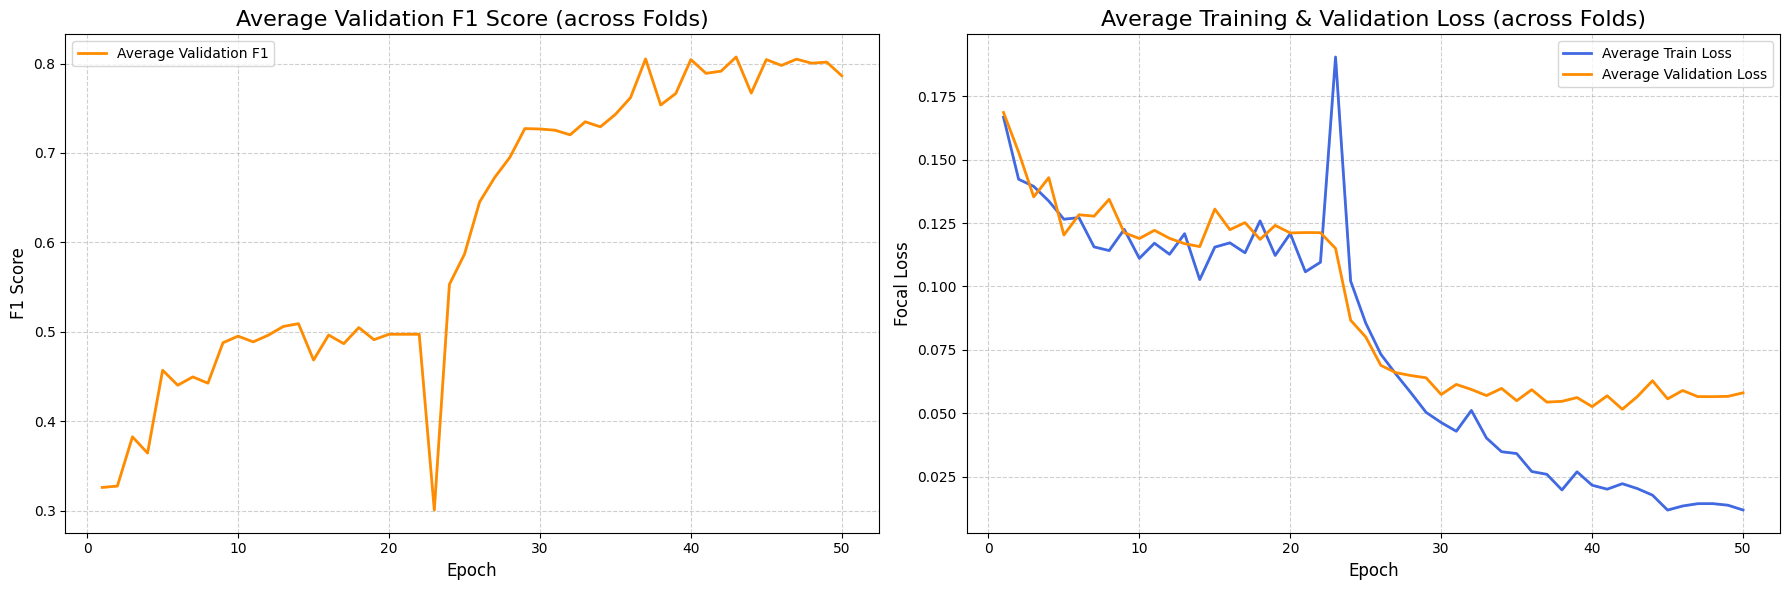

In [25]:
#       VISUALIZE TRAINING HISTORY 
# Plotting the AVERAGE learning curves across all K folds)
import matplotlib.pyplot as plt
import numpy as np

def plot_average_history(histories):
    """
    Plots the average training and validation loss and F1 scores across all folds.
    """
    print("\n--- Plotting average training history across all folds ---")
    
    if not histories:
        print("History object list is empty. Skipping plotting.")
        return

    # Create a figure with two subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Calculate average and std dev for each metric
    min_epochs = min([len(h['val_loss']) for h in histories])
    val_f1_scores = np.array([h['val_f1_score'][:min_epochs] for h in histories])
    
    val_loss_scores = np.array([h['val_loss'][:min_epochs] for h in histories])
    train_loss_scores = np.array([h['loss'][:min_epochs] for h in histories])

    # Calculate the mean and standard deviation across the folds for each epoch.
    mean_val_f1 = np.mean(val_f1_scores, axis=0)
    std_val_f1 = np.std(val_f1_scores, axis=0)
    
    mean_val_loss = np.mean(val_loss_scores, axis=0)
    std_val_loss = np.std(val_loss_scores, axis=0)
    
    mean_train_loss = np.mean(train_loss_scores, axis=0)
    std_train_loss = np.std(train_loss_scores, axis=0)
    
    epochs = range(1, min_epochs + 1)

    # Plot 1: Average Validation F1 Score 
    ax1.plot(epochs, mean_val_f1, label='Average Validation F1', color='darkorange', lw=2)
    # Add a shaded region for the standard deviation.
    ax1.fill_between(epochs, mean_val_f1 - std_val_f1, mean_val_f1 + std_val_f1, color='darkorange', alpha=0.2)
    ax1.set_title('Average Validation F1 Score (across Folds)', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    #  Plot 2: Average Training & Validation Loss 
    ax2.plot(epochs, mean_train_loss, label='Average Train Loss', color='royalblue', lw=2)
    ax2.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='royalblue', alpha=0.2)
    
    ax2.plot(epochs, mean_val_loss, label='Average Validation Loss', color='darkorange', lw=2)
    ax2.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='darkorange', alpha=0.2)

    ax2.set_title('Average Training & Validation Loss (across Folds)', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Focal Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Call the new plotting function with our list of histories.
plot_average_history(oof_histories)

# 15. Classification Report

In [26]:
# CLASSIFICATION METRIC
from sklearn.metrics import classification_report, f1_score
import numpy as np

print("--- Starting Detailed Model Evaluation ---")

# Define the model weights path and validation dataset to use
print("Mode: Single 80/20 Split. Evaluating the single trained model.")
model_weights_path = "best_model_single_split.weights.h5"
val_ds_for_eval = val_dataset # Use the dataset object directly

# Extract the true labels for the classification report
# We iterate through the dataset to get all the true labels.
print("Extracting true labels from the validation dataset...")
y_val_true = np.concatenate([y for x, y in val_ds_for_eval], axis=0)
print(f"Validation data and {len(y_val_true)} true labels are ready.")

# Build a fresh model instance and load the best weights 
print(f"Loading best model weights from: {model_weights_path}")
with strategy.scope():
    evaluation_model = build_and_compile_model() 
    evaluation_model.load_weights(model_weights_path)
print("Best weights loaded successfully into new model instance.")

# Get Predictions on the validation set 
print("\n--- Getting predictions... ---")
val_pred_proba = evaluation_model.predict(val_ds_for_eval)

# Search for the Best Decision Threshold 
print("\n--- Searching for the optimal decision threshold... ---")
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_val_pred_binary = (val_pred_proba > threshold).astype(int)
    current_f1 = f1_score(y_val_true, y_val_pred_binary)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"Optimal threshold found: {best_threshold:.2f}")
print(f"Best F1 Score on this validation set: {best_f1:.4f}")

# Display a Full Classification Report 
print(f"\n--- Classification Report (using optimal threshold of {best_threshold:.2f}) ---\n")
y_val_pred_optimal = (val_pred_proba > best_threshold).astype(int)
print(classification_report(y_val_true, y_val_pred_optimal, target_names=['No Landslide (0)', 'Landslide (1)']))

--- Starting Detailed Model Evaluation ---
Mode: Single 80/20 Split. Evaluating the single trained model.
Extracting true labels from the validation dataset...
Validation data and 1430 true labels are ready.
Loading best model weights from: best_model_single_split.weights.h5
--- Model built and compiled successfully with efficient F1 metric. ---
Best weights loaded successfully into new model instance.

--- Getting predictions... ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 751ms/step

--- Searching for the optimal decision threshold... ---
Optimal threshold found: 0.65
Best F1 Score on this validation set: 0.8134

--- Classification Report (using optimal threshold of 0.65) ---

                  precision    recall  f1-score   support

No Landslide (0)       0.96      0.96      0.96      1179
   Landslide (1)       0.80      0.82      0.81       251

        accuracy                           0.93      1430
       macro avg       0.88      0.89      0.89      1430
    weighted avg       0.93   

# Load Best Model and Evaluate on Validation Set
This cell performs the definitive evaluation of our best model on the data it didn't train on. It answers the question: "How well did our model truly perform?"

# 16. Create the Test Dataset
First, we need to create a tf.data.Dataset for our test images. We will use our powerful build_dataset functioN.

In [27]:
# CREATE THE TEST DATASET

def get_parse_test_function(stats):
    """
    This is a factory that creates our TEST data parsing function. 
    It "closes over" the stats dictionary, making it available for normalization.
    """
    # Convert the stats dictionary to a TensorFlow constant
    stats_tensor = {k: tf.constant(v, dtype=tf.float32) for k, v in stats.items()}

    @tf.function
    def parse_test_tfrecord_function(example_proto):
        """
        Parses a single tf.train.Example proto for TEST data.
        """
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'id': tf.io.FixedLenFeature([], tf.string),
        }
        
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        
        # Decode and Reshape the Base Image 
        image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float64)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, [*Config.IMAGE_SIZE, 12])
        
        # Call the feature engineering function, which now returns ONE tensor
        image_with_features = engineer_features(image, stats_tensor)
        
        # Standard Preprocessing on the final combined tensor
        image_resized = tf.image.resize(image_with_features, Config.TARGET_SIZE, method='bilinear')
        image_scaled = image_resized / 255.0
        
        final_image = tf.ensure_shape(image_scaled, [*Config.TARGET_SIZE, Config.N_CHANNELS])
        image_id = parsed_features['id']
        
        return final_image, image_id

    return parse_test_tfrecord_function

# --- Second, define the build function for the test dataset ---
def build_test_dataset(tfrecord_path, stats):
    """
    Builds a high-performance tf.data.Dataset for inference.
    It now requires the global_stats to create the correct parser.
    """
    # Create the specific parsing function for this dataset
    parse_fn = get_parse_test_function(stats)
    
    dataset = tf.data.TFRecordDataset(tfrecord_path, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(Config.BATCH_SIZE, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# --- Execute the build process ---
print("--- Building final test dataset for inference (with unified feature engineering)... ---\n")
# The global_stats dictionary should be available from a previous cell
if 'global_stats' in locals():
    test_dataset = build_test_dataset(TEST_TFRECORD_PATH, global_stats)
    print("--- Test dataset built successfully. ---")
    
    # Sanity check to confirm the output shapes
    print("\n--- Inspecting a batch from the test dataset... ---")
    for images, ids in test_dataset.take(1):
        print("Image batch shape:", images.shape)
        print("ID batch shape:", ids.shape)
else:
    print("ERROR: `global_stats` dictionary not found. Please run the cell that calculates global statistics first.")

--- Building final test dataset for inference (with unified feature engineering)... ---

--- Test dataset built successfully. ---

--- Inspecting a batch from the test dataset... ---
Image batch shape: (128, 224, 224, 14)
ID batch shape: (128,)


# 17. Ensemble Predictions and Create Submission File
Runs the final inference, formats the output, and saves the file 

1. Iterative Loading: It loops from 1 to 5, loading the weights from each of your saved "expert" models (model_fold_1.weights.h5, model_fold_2.weights.h5, etc.).

2. Prediction Gathering: It gets a separate set of predictions on the test data from each of the 5 models.

3. Ensembling: It takes the average of these 5 sets of predictions. This final ensembled_predictions array is more robust and less prone to individual model errors than any single prediction would be.

4. Submission: It creates the submission.csv using these final, averaged probabilities, ensuring compliance with the competition rules.

In [28]:
#  PREDICT ON TEST SET & CREATE SUBMISSION (ADAPTIVE VERSION)

# This logic will decide whether to ensemble or do a single prediction 
if Config.USE_CROSS_VALIDATION:
    print("--- Mode: Cross-Validation. Starting ENSEMBLE process for submission. ---\n")
    all_fold_predictions = []

    # Loop through each saved model, load its weights, and get predictions.
    for fold_n in range(1, Config.N_FOLDS + 1):
        fold_model_path = f"model_fold_{fold_n}.weights.h5"
        print(f"--- Loading model and predicting for Fold {fold_n} ---")
        
        with strategy.scope():
            prediction_model = build_and_compile_model()
        
        prediction_model.load_weights(fold_model_path)
        
        # The model.predict uses only the first element (images) from the test_dataset.
        fold_predictions = prediction_model.predict(test_dataset)
        all_fold_predictions.append(fold_predictions)

    print("\n--- All folds predicted. Averaging predictions... ---")
    # Ensemble the Predictions by Averaging
    final_predictions = np.mean(all_fold_predictions, axis=0)

else:
    print("--- Mode: Single 80/20 Split. Predicting with the SINGLE best model. ---")
    # NOTE: This is NOT an ensemble.
    model_weights_path = "best_model_single_split.weights.h5"
    print(f"Loading model: {model_weights_path}")

    with strategy.scope():
        prediction_model = build_and_compile_model()
    
    prediction_model.load_weights(model_weights_path)
    
    print("Model loaded. Generating predictions on the test set...")
    final_predictions = prediction_model.predict(test_dataset)

# --- Create and Save the Final Submission File (This part is now universal) ---
print("\n--- Creating final submission file... ---")

# We use the best_threshold that was calculated in the evaluation cell just before this one.
if 'best_threshold' not in locals():
    print("Warning: 'best_threshold' not found. Using default of 0.5 for submission.")
    best_threshold = 0.5
else:
    print(f"Using the optimal threshold found earlier: {best_threshold:.2f}")

submission_df = pd.DataFrame({
    'ID': test_df['ID'].values,
    'Target': (final_predictions.flatten() > best_threshold).astype(int)
})

# Final check to make sure the lengths match.
if len(submission_df) != len(test_df):
    raise ValueError(f"Submission length ({len(submission_df)}) does not match Test DF length ({len(test_df)})!")

submission_filepath = 'submission13.csv'
submission_df.to_csv(submission_filepath, index=False)

print(f"\n--- Submission file created successfully! ---")
print(f"File saved at: {submission_filepath}")
print("\nSubmission file head:")
print(submission_df.head())

--- Mode: Single 80/20 Split. Predicting with the SINGLE best model. ---
Loading model: best_model_single_split.weights.h5
--- Model built and compiled successfully with efficient F1 metric. ---
Model loaded. Generating predictions on the test set...
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 894ms/step

--- Creating final submission file... ---
Using the optimal threshold found earlier: 0.65

--- Submission file created successfully! ---
File saved at: submission13.csv

Submission file head:
          ID  Target
0  ID_ICB8K9       0
1  ID_2D4AOJ       0
2  ID_2TVPI0       0
3  ID_E05WIK       0
4  ID_KKFDJO       0


In [29]:
# In Cell 35

# ... (prediction logic) ...

print("\n--- Creating final submission file... ---\n")

submission_threshold = 0.5 # Use a standard, robust threshold
print(f"Using a standard threshold of {submission_threshold} for this submission.")

# This line correctly converts the final probabilities to binary 0s and 1s
submission_df = pd.DataFrame({
    'ID': test_df['ID'].values,
    'Target': (final_predictions.flatten() > submission_threshold).astype(int) 
})

submission_filepath = 'submission.csv'
submission_df.to_csv(submission_filepath, index=False)

print(f"\n--- Submission file created successfully! ---\n")
print(submission_df.head())


--- Creating final submission file... ---

Using a standard threshold of 0.5 for this submission.

--- Submission file created successfully! ---

          ID  Target
0  ID_ICB8K9       0
1  ID_2D4AOJ       0
2  ID_2TVPI0       0
3  ID_E05WIK       0
4  ID_KKFDJO       1


In [30]:
# PREDICT ON TEST SET & CREATE SUBMISSION (FROM SAVED MODEL)

print("--- Predicting with the SINGLE best model from the previous run. ---")

# Define the path to your saved model weights
# This file should be in your notebook's output directory, e.g., /kaggle/working/
model_weights_path = "best_model_single_split.weights.h5" 
print(f"Loading model weights from: {model_weights_path}")

# Build a fresh model instance (must be the same architecture)
with strategy.scope():
    prediction_model = build_and_compile_model()

# Load the weights you saved from your best epoch
prediction_model.load_weights(model_weights_path)
print("Model loaded successfully.")

# Generate predictions on the test set
print("Generating predictions on the test set...")
final_predictions = prediction_model.predict(test_dataset)


# --- Create and Save the Final Submission File ---
print("\n--- Creating final submission file... ---\n")

# Use the standard 0.5 threshold as discussed
submission_threshold = 0.5
print(f"Using a standard, robust threshold of {submission_threshold} for this submission.")

submission_df = pd.DataFrame({
    'ID': test_df['ID'].values,
    'Target': (final_predictions.flatten() > submission_threshold).astype(int)
})

# Final check to make sure the lengths match.
if len(submission_df) != len(test_df):
    raise ValueError(f"Submission length ({len(submission_df)}) does not match Test DF length ({len(test_df)})!")

submission_filepath = 'submission_0.5_threshold.csv' # Give it a new name
submission_df.to_csv(submission_filepath, index=False)

print(f"--- Submission file created successfully! ---")
print(f"File saved at: {submission_filepath}")
print("\nSubmission file head:")
print(submission_df.head())

--- Predicting with the SINGLE best model from the previous run. ---
Loading model weights from: best_model_single_split.weights.h5
--- Model built and compiled successfully with efficient F1 metric. ---
Model loaded successfully.
Generating predictions on the test set...
43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 875ms/step

--- Creating final submission file... ---

Using a standard, robust threshold of 0.5 for this submission.
--- Submission file created successfully! ---
File saved at: submission_0.5_threshold.csv

Submission file head:
          ID  Target
0  ID_ICB8K9       0
1  ID_2D4AOJ       0
2  ID_2TVPI0       0
3  ID_E05WIK       0
4  ID_KKFDJO       1


- The notebook that:

1. Structured and Modular: Easy to read, debug, and reuse.

2. Performant: Uses a tf.data pipeline to keep the accelerator fully utilized.

3. Flexible: Can be switched between CPU, single-GPU, and multi-GPU modes with a single flag.

4. Robust: Uses K-Fold Cross-Validation for reliable evaluation.

5. State-of-the-Art: Implements ensembling for the most accurate final predictions.